In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
# Colab: mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LSTM_Model.h5: Unrecognized keyword arguments passed to LSTM: {'time_major': False}
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LSTM_Model
[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_TinyFormer_Model.h5: bad marshal data (unknown type code)
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_TinyFormer_Model
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiPFormer_Model
[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiteFormer_Model.h5: bad marshal data (unknown type code)
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiteFormer_Model
[warn] .keras load failed for /content/drive/MyDrive/EdgeMeter_AIv2/data/Final_TinyFormer_Model_48_12.keras: The `funct

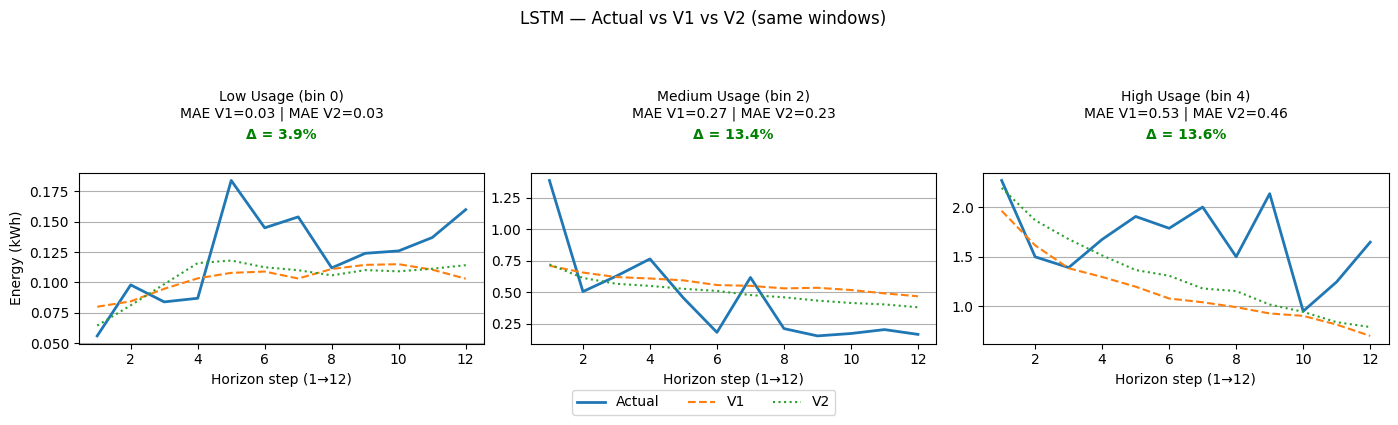

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final/plots_by_model/LSTM__bins_0_2_4.png
[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/LSTM__bins_0_2_4.png


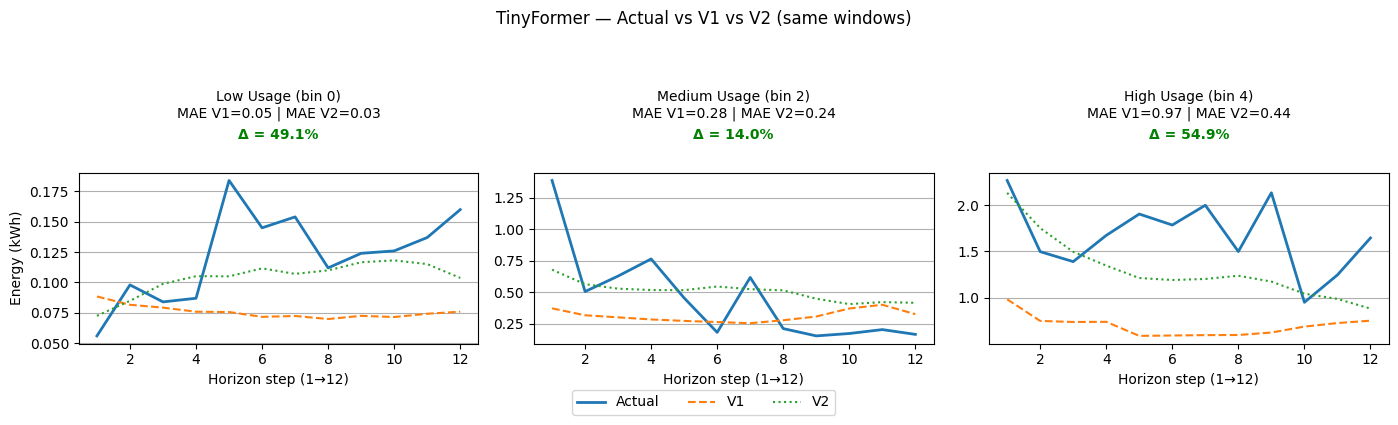

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final/plots_by_model/TinyFormer__bins_0_2_4.png
[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/TinyFormer__bins_0_2_4.png


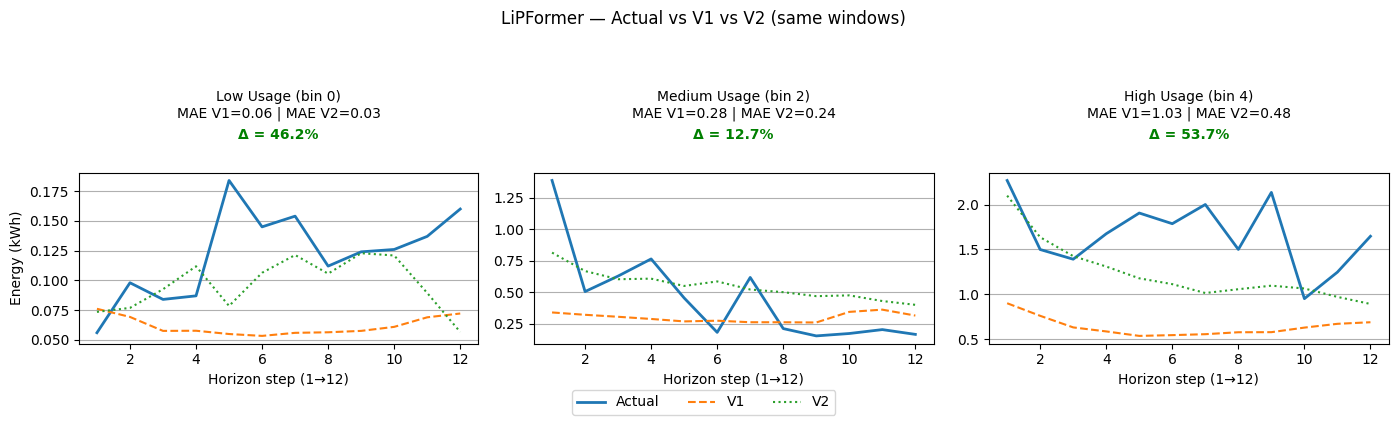

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final/plots_by_model/LiPFormer__bins_0_2_4.png
[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/LiPFormer__bins_0_2_4.png


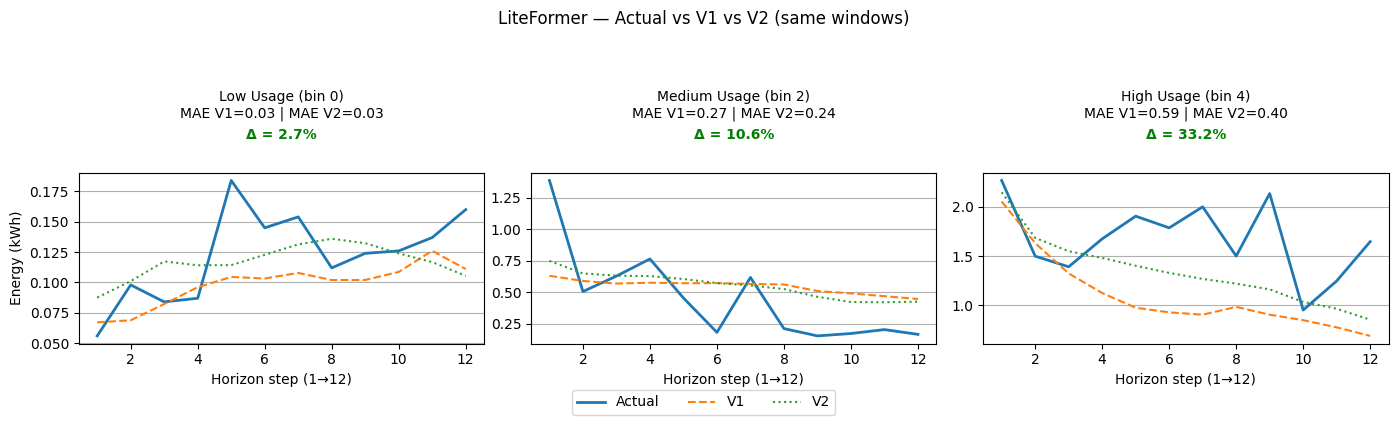

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final/plots_by_model/LiteFormer__bins_0_2_4.png
[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/LiteFormer__bins_0_2_4.png
[DONE] All plots saved in: /content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final/plots_by_model and /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final


In [ ]:
# Paths
BASE_V2 = r"/content/drive/MyDrive/EdgeMeter_AIv2/data"
X_DEMO_PATH = os.path.join(BASE_V2, "X_demo_48_12.npy")
Y_DEMO_PATH = os.path.join(BASE_V2, "y_demo_48_12.npy")

V1_MODEL_DIR = r"/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
V2_MODEL_DIR = r"/content/drive/MyDrive/EdgeMeter_AIv2/data"

V1_BASENAMES = {
    "LSTM":       "Final_LSTM_Model",
    "TinyFormer": "Final_TinyFormer_Model",
    "LiPFormer":  "Final_LiPFormer_Model",
    "LiteFormer": "Final_LiteFormer_Model",
}
V2_BASENAMES = {
    "LSTM":       "Final_LSTM_Model_48_12",
    "TinyFormer": "Final_TinyFormer_Model_48_12",
    "LiPFormer":  "Final_LiPFormer_Model_48_12",
    "LiteFormer": "Final_LiteFormer_Model_48_12",
}

V2_CONSUMPTION_COL = 0
V2_USAGE_BIN_COL   = 10

TARGET_BINS = [0, 2, 4]
BIN_LABELS = {0: "Low Usage", 2: "Medium Usage", 4: "High Usage"}

OUTDIR       = "/content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final"
PLOT_DIR     = os.path.join(OUTDIR, "plots_by_model")
PLOT_DIR_V2  = os.path.join(V2_MODEL_DIR, "Model_Comparison_Final")
TAB_DIR      = os.path.join(OUTDIR, "tables")
TAB_DIR_V2   = os.path.join(V2_MODEL_DIR, "Model_Comparison_Final", "tables")

os.makedirs(PLOT_DIR, exist_ok=True)
os.makedirs(PLOT_DIR_V2, exist_ok=True)
os.makedirs(TAB_DIR, exist_ok=True)
os.makedirs(TAB_DIR_V2, exist_ok=True)

SEL_CSV_MAIN = os.path.join(TAB_DIR, "demo_bin_selection.csv")
SEL_CSV_V2   = os.path.join(TAB_DIR_V2, "demo_bin_selection.csv")

# Loaders
class SavedModelRunner:
    def __init__(self, savedmodel_dir: str):
        obj = tf.saved_model.load(savedmodel_dir)
        fn = obj.signatures.get("serving_default")
        if fn is None:
            sigs = list(obj.signatures.keys())
            if not sigs:
                raise ValueError(f"No signatures in SavedModel: {savedmodel_dir}")
            fn = obj.signatures[sigs[0]]
        self.fn = fn
        self._input_keys = list(self.fn.structured_input_signature[1].keys())
        self._output_keys = list(self.fn.structured_outputs.keys())
    def predict(self, x, verbose=0):
        x = tf.convert_to_tensor(x)
        out = self.fn(**{self._input_keys[0]: x})
        return out[self._output_keys[0]].numpy()

def _try_load_any(base_dir, basename):
    p_keras = os.path.join(base_dir, basename + ".keras")
    p_h5    = os.path.join(base_dir, basename + ".h5")
    p_dir   = os.path.join(base_dir, basename)
    if os.path.exists(p_keras):
        try: return keras.models.load_model(p_keras, compile=False)
        except Exception as e: print(f"[warn] .keras load failed for {p_keras}: {e}")
    if os.path.exists(p_h5):
        try: return keras.models.load_model(p_h5, compile=False)
        except Exception as e: print(f"[warn] .h5 load failed for {p_h5}: {e}")
    if os.path.isdir(p_dir):
        print(f"[info] Using SavedModelRunner for: {p_dir}")
        return SavedModelRunner(p_dir)
    raise FileNotFoundError(f"No loadable artifact for base '{basename}' in {base_dir}")

def load_models(base_dir, basenames):
    return {name: _try_load_any(base_dir, base) for name, base in basenames.items()}

# Utilities
def pick_from_csv_or_last(X_v2, sel_csv_main, sel_csv_v2, bins=(0,2,4)):
    if os.path.exists(sel_csv_main):
        sel = pd.read_csv(sel_csv_main)
        return {int(r["bin"]): int(r["row_idx"]) for _, r in sel.iterrows() if int(r["bin"]) in bins}
    usage_bins = X_v2[:, -1, V2_USAGE_BIN_COL].astype(int)
    picks = {}
    for b in bins:
        idxs = np.where(usage_bins == b)[0]
        if idxs.size:
            picks[b] = int(idxs[-1])
    df_sel = pd.DataFrame([{"bin": b, "label": BIN_LABELS[b], "row_idx": i} for b, i in picks.items()])
    df_sel.to_csv(sel_csv_main, index=False)
    df_sel.to_csv(sel_csv_v2, index=False)
    return picks

def _pred_once(model_obj, x):
    p = model_obj.predict(x, verbose=0)
    if isinstance(p, dict):
        if "output_0" in p:
            arr = np.array(p["output_0"])
        else:
            arr = np.array(next(iter(p.values())))
    else:
        arr = np.array(p)
    return arr[0].astype(np.float32)

def safe_predict(model_obj, x, model_name=None, version_tag=None):
    x = np.asarray(x, dtype=np.float32, order="C")
    try:
        return _pred_once(model_obj, x)
    except tf.errors.InternalError as e:
        if "CudnnRNN" in str(e) or "DoRnnForward" in str(e):
            print(f"[warn] CuDNN error for {model_name or ''} {version_tag or ''} — retrying on CPU...")
            with tf.device("/CPU:0"):
                return _pred_once(model_obj, x)
        raise

# Main
def main():
    # Load arrays
    X_v2 = np.load(X_DEMO_PATH).astype(np.float32)
    y    = np.load(Y_DEMO_PATH).astype(np.float32)
    X_v1 = X_v2[:, :, [V2_CONSUMPTION_COL]]

    # Selection
    picks = pick_from_csv_or_last(X_v2, SEL_CSV_MAIN, SEL_CSV_V2, TARGET_BINS)
    if not picks:
        raise RuntimeError("No samples found for requested bins.")

    # Loading models
    models_v1 = load_models(V1_MODEL_DIR, V1_BASENAMES)
    models_v2 = load_models(V2_MODEL_DIR, V2_BASENAMES)

    # Plot: one figure per model
    for model_name in ["LSTM", "TinyFormer", "LiPFormer", "LiteFormer"]:
        fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharey=False)

        for j, b in enumerate(TARGET_BINS):
            ax = axes[j]
            if b not in picks:
                ax.set_title(f"{BIN_LABELS.get(b,'Unknown')} (bin {b}) — no sample")
                ax.axis("off")
                continue

            idx = picks[b]
            x1, x2 = X_v1[idx:idx+1], X_v2[idx:idx+1]
            y_true = y[idx]

            y_pred_v1 = safe_predict(models_v1[model_name], x1, model_name=model_name, version_tag="V1")
            y_pred_v2 = safe_predict(models_v2[model_name], x2, model_name=model_name, version_tag="V2")

            mae_v1 = float(np.mean(np.abs(y_true - y_pred_v1)))
            mae_v2 = float(np.mean(np.abs(y_true - y_pred_v2)))
            improvement = ((mae_v1 - mae_v2) / mae_v1) * 100

            h = np.arange(1, len(y_true) + 1)
            ax.plot(h, y_true, label="Actual", linewidth=2)
            ax.plot(h, y_pred_v1, "--", label="V1")
            ax.plot(h, y_pred_v2, ":",  label="V2")

            # TITLE
            title_txt = f"{BIN_LABELS[b]} (bin {b})\nMAE V1={mae_v1:.2f} | MAE V2={mae_v2:.2f}"
            ax.set_title(title_txt, fontsize=10, color="black", pad=40)

            delta_color = "green" if improvement > 0 else "red"

            ax.text(
                0.5, 1.18, f"Δ = {improvement:.1f}%",
                transform=ax.transAxes,
                ha="center", va="bottom",
                fontsize=10, fontweight="bold", color=delta_color
                )


            ax.set_xlabel("Horizon step (1→12)")
            if j == 0:
                ax.set_ylabel("Energy (kWh)")
            ax.grid(True, axis="y")

        handles, labels = axes[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5, -0.05))
        fig.suptitle(f"{model_name} — Actual vs V1 vs V2 (same windows)", y=0.98, fontsize=12)
        fig.tight_layout(rect=[0, 0, 1, 0.90])

        out_name = f"{model_name}__bins_0_2_4.png"
        out_path_main = os.path.join(PLOT_DIR, out_name)
        out_path_v2   = os.path.join(PLOT_DIR_V2, out_name)
        fig.savefig(out_path_main, dpi=220, bbox_inches="tight")
        fig.savefig(out_path_v2, dpi=220, bbox_inches="tight")
        plt.show(fig)

        print(f"[OK] Saved: {out_path_main}")
        print(f"[OK] Saved: {out_path_v2}")

    print(f"[DONE] All plots saved in: {PLOT_DIR} and {PLOT_DIR_V2}")

if __name__ == "__main__":
    main()


[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LSTM_Model.h5: Unrecognized keyword arguments passed to LSTM: {'time_major': False}
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LSTM_Model
[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_TinyFormer_Model.h5: bad marshal data (unknown type code)
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_TinyFormer_Model
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiPFormer_Model
[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiteFormer_Model.h5: bad marshal data (unknown type code)
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiteFormer_Model
[warn] .keras load failed for /content/drive/MyDrive/EdgeMeter_AIv2/data/Final_TinyFormer_Model_48_12.keras: The `funct

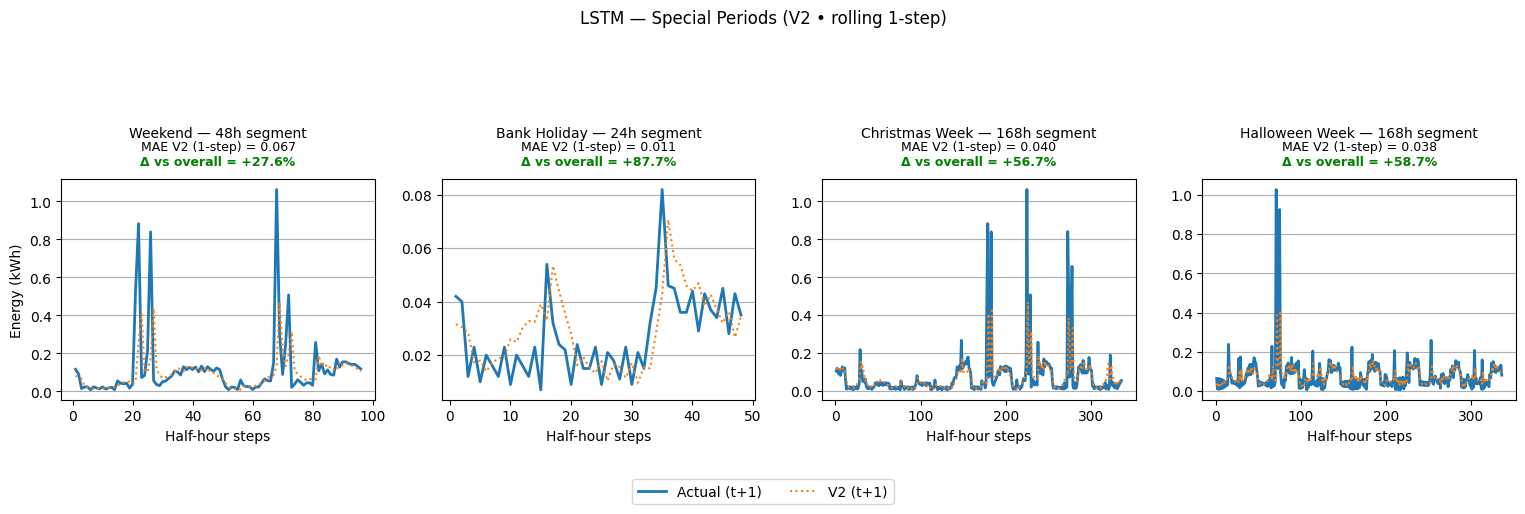

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/special_periods/LSTM__special_periods_V2_rolling1step.png


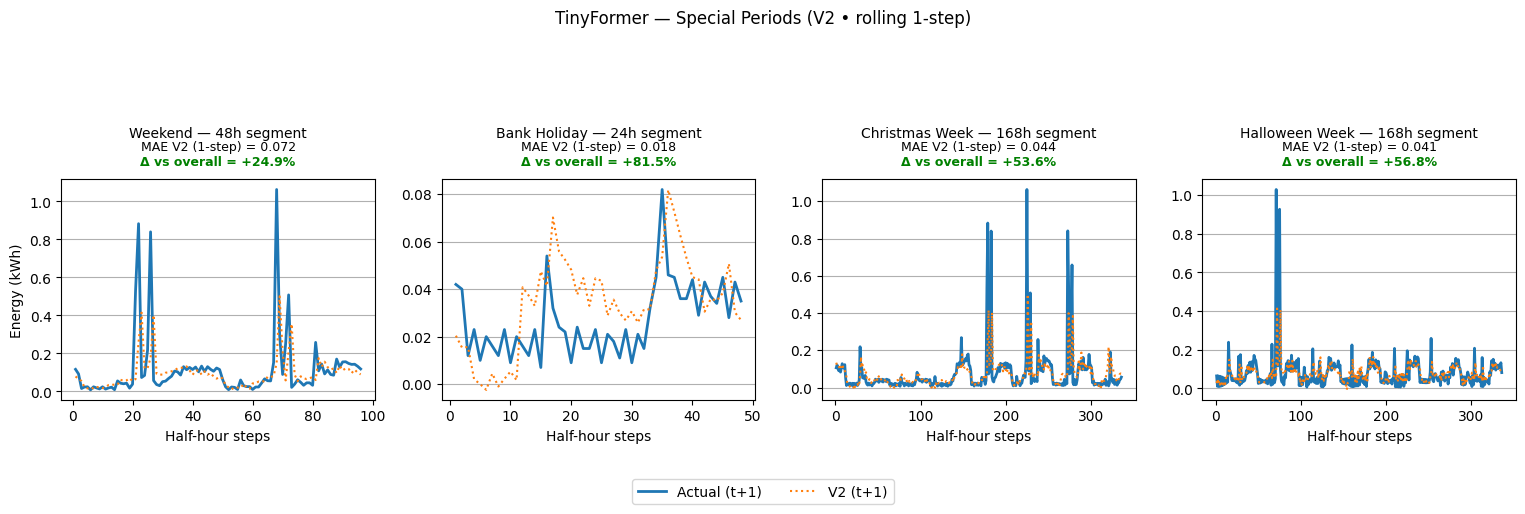

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/special_periods/TinyFormer__special_periods_V2_rolling1step.png


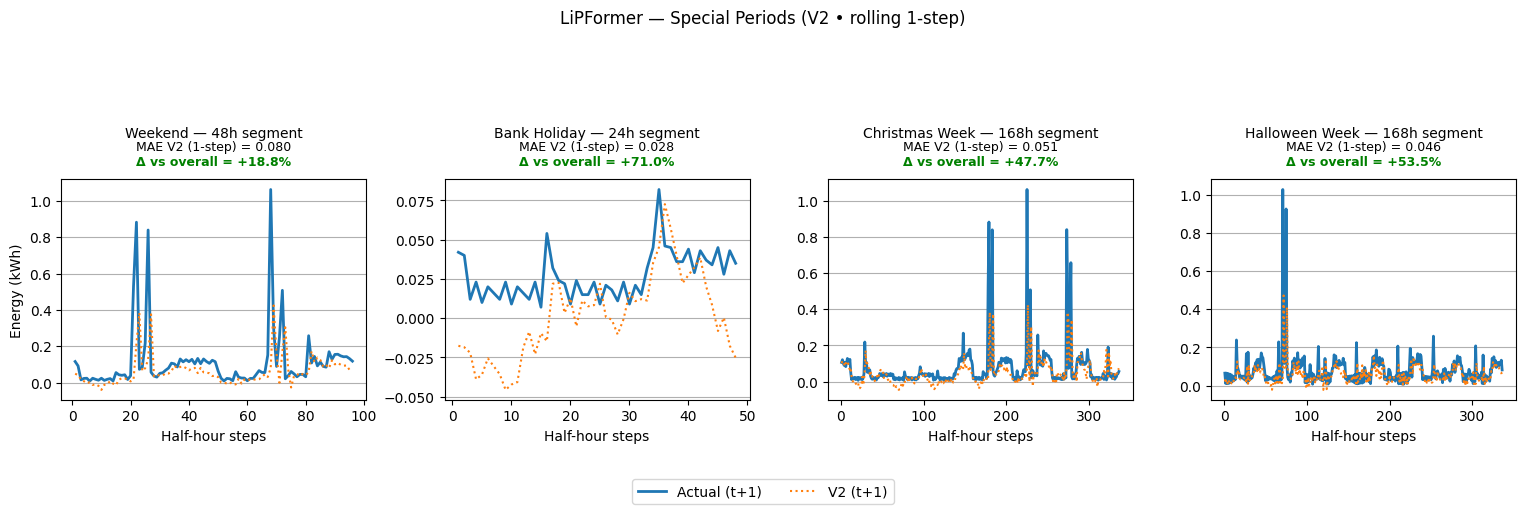

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/special_periods/LiPFormer__special_periods_V2_rolling1step.png


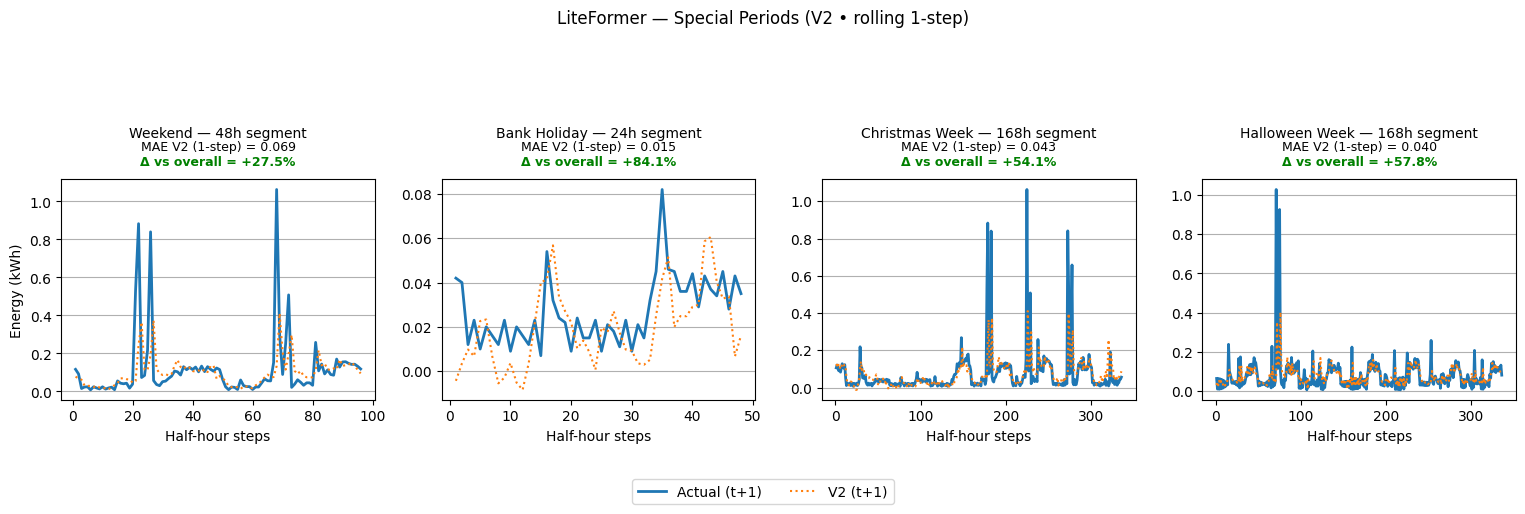

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/special_periods/LiteFormer__special_periods_V2_rolling1step.png


In [ ]:
# V2-ONLY Seasonal/Contextual plots (1 fig per model, 4 subplots)
# Rolling 1-step-ahead across continuous segments

# Loading arrays
X_v2 = np.load(X_DEMO_PATH).astype(np.float32)
y    = np.load(Y_DEMO_PATH).astype(np.float32)
X_v1 = X_v2[:, :, [V2_CONSUMPTION_COL]]

# Loading models
models_v1 = load_models(V1_MODEL_DIR, V1_BASENAMES)
models_v2 = load_models(V2_MODEL_DIR, V2_BASENAMES)



# Feature indices in X_v2 (last step of 48-step window)
IX_MONTH   = 7
IX_WEEKEND = 8
IX_HOLIDAY = 9

# Desired segment lengths in half-hours
TARGET_LEN = {
    "Weekend":        96,   # 48h
    "Bank Holiday":   48,   # 24h
    "Christmas Week": 336,  # 168h
    "Halloween Week": 336,  # 168h
}

# Building boolean masks from X_v2 flags (aligned to windows)
month_vals      = X_v2[:, -1, IX_MONTH].astype(int)
is_weekend      = (X_v2[:, -1, IX_WEEKEND].astype(int) == 1)
is_bank_holiday = (X_v2[:, -1, IX_HOLIDAY].astype(int) == 1)
# If explicit week flags aren’t in X_v2, approximate with month:
is_christmas_week = (month_vals == 12)
is_halloween_week = (month_vals == 10)

PERIOD_MASKS = {
    "Weekend":        is_weekend,
    "Bank Holiday":   is_bank_holiday,
    "Christmas Week": is_christmas_week,
    "Halloween Week": is_halloween_week,
}
PERIOD_ORDER = ["Weekend", "Bank Holiday", "Christmas Week", "Halloween Week"]

# Helpers
def _predict_batch_first_step(model_obj, X):
    """Return first-horizon predictions for a batch, robust to dict outputs/SavedModel."""
    preds = model_obj.predict(X, verbose=0)
    if isinstance(preds, dict):
        if "output_0" in preds:
            arr = np.array(preds["output_0"])
        else:
            arr = np.array(next(iter(preds.values())))
    else:
        arr = np.array(preds)
    return arr[:, 0].astype(np.float32)  # first horizon

def _overall_first_step_mae(model_obj, X, y_true):
    """Global V2 baseline (1-step MAE) over entire demo set."""
    try:
        pred_first = _predict_batch_first_step(model_obj, X)
    except tf.errors.InternalError:
        with tf.device("/CPU:0"):
            pred_first = _predict_batch_first_step(model_obj, X)
    return float(np.mean(np.abs(y_true[:, 0] - pred_first)))

def _longest_or_target_segment(mask, target_len):
    """
    Find the last segment with length >= target_len;
    else return the longest contiguous True run.
    Returns (start_idx, end_idx_inclusive) or None.
    """
    mask = np.asarray(mask, dtype=bool)
    if mask.sum() == 0:
        return None
    runs = []
    start = None
    for i, val in enumerate(mask):
        if val and start is None:
            start = i
        if (not val or i == len(mask) - 1) and start is not None:
            end = i if val else i - 1
            runs.append((start, end))
            start = None
    # Prefer last run meeting target
    for st, en in reversed(runs):
        if (en - st + 1) >= target_len:
            return (en - target_len + 1, en)
    # Else longest run
    lengths = [(en - st + 1, st, en) for st, en in runs]
    lengths.sort()
    _, st, en = lengths[-1]
    return (st, en)

# Output dir
SPECIAL_DIR = os.path.join(PLOT_DIR_V2, "special_periods")
os.makedirs(SPECIAL_DIR, exist_ok=True)

# Plot for each model
for model_name in ["LSTM","TinyFormer","LiPFormer","LiteFormer"]:
    model_v2 = models_v2[model_name]
    base_mae = _overall_first_step_mae(model_v2, X_v2, y)  # global baseline (1-step MAE)

    fig, axes = plt.subplots(1, len(PERIOD_ORDER), figsize=(16, 4.8), sharey=False)
    if len(PERIOD_ORDER) == 1:
        axes = [axes]

    for j, pname in enumerate(PERIOD_ORDER):
        ax = axes[j]
        mask = PERIOD_MASKS[pname]
        target = TARGET_LEN[pname]
        seg = _longest_or_target_segment(mask, target)
        if seg is None:
            ax.set_title(f"{pname} — no data", fontsize=10, color="black")
            ax.axis("off")
            continue

        st, en = seg  # inclusive
        X_seg = X_v2[st:en+1]
        y_seg = y[st:en+1]

        # rolling 1-step across segment
        try:
            pred_first = _predict_batch_first_step(model_v2, X_seg)
        except tf.errors.InternalError:
            with tf.device("/CPU:0"):
                pred_first = _predict_batch_first_step(model_v2, X_seg)

        mae_seg = float(np.mean(np.abs(y_seg[:, 0] - pred_first)))
        delta_pct = ((base_mae - mae_seg) / base_mae) * 100.0 if base_mae > 0 else 0.0
        delta_color = "green" if delta_pct >= 0 else "red"

        h = np.arange(1, len(pred_first) + 1)
        ax.plot(h, y_seg[:, 0], label="Actual (t+1)", linewidth=2)
        ax.plot(h, pred_first, ":", label="V2 (t+1)")

        dur_hours = len(pred_first) / 2.0  # half-hour steps


        # Title
        ax.set_title(f"{pname} — {dur_hours:.0f}h segment",
                     fontsize=10, color="black", pad=30)
        # MAE
        ax.text(0.5, 1.12, f"MAE V2 (1-step) = {mae_seg:.3f}",
                transform=ax.transAxes, ha="center", va="bottom",
                fontsize=9, color="black")
        # Δ vs overall (green/red)
        ax.text(0.5, 1.05, f"Δ vs overall = {delta_pct:+.1f}%",
                transform=ax.transAxes, ha="center", va="bottom",
                fontsize=9, fontweight="bold", color=delta_color)

        ax.set_xlabel("Half-hour steps")
        if j == 0:
            ax.set_ylabel("Energy (kWh)")
        ax.grid(True, axis="y")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.05))
    fig.suptitle(f"{model_name} — Special Periods (V2 • rolling 1-step)", y=0.995, fontsize=12)
    fig.tight_layout(rect=[0.02, 0.06, 0.98, 0.86])

    out_path = os.path.join(SPECIAL_DIR, f"{model_name}__special_periods_V2_rolling1step.png")
    fig.savefig(out_path, dpi=220, bbox_inches="tight")
    plt.show(fig)
    plt.close(fig)
    print(f"[OK] Saved: {out_path}")


[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LSTM_Model.h5: Unrecognized keyword arguments passed to LSTM: {'time_major': False}
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LSTM_Model
[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_TinyFormer_Model.h5: bad marshal data (unknown type code)
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_TinyFormer_Model
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiPFormer_Model
[warn] .h5 load failed for /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiteFormer_Model.h5: bad marshal data (unknown type code)
[info] Using SavedModelRunner for: /content/drive/MyDrive/EdgeMeter_AI/Data/processed/Final_LiteFormer_Model
[warn] .keras load failed for /content/drive/MyDrive/EdgeMeter_AIv2/data/Final_TinyFormer_Model_48_12.keras: The `funct

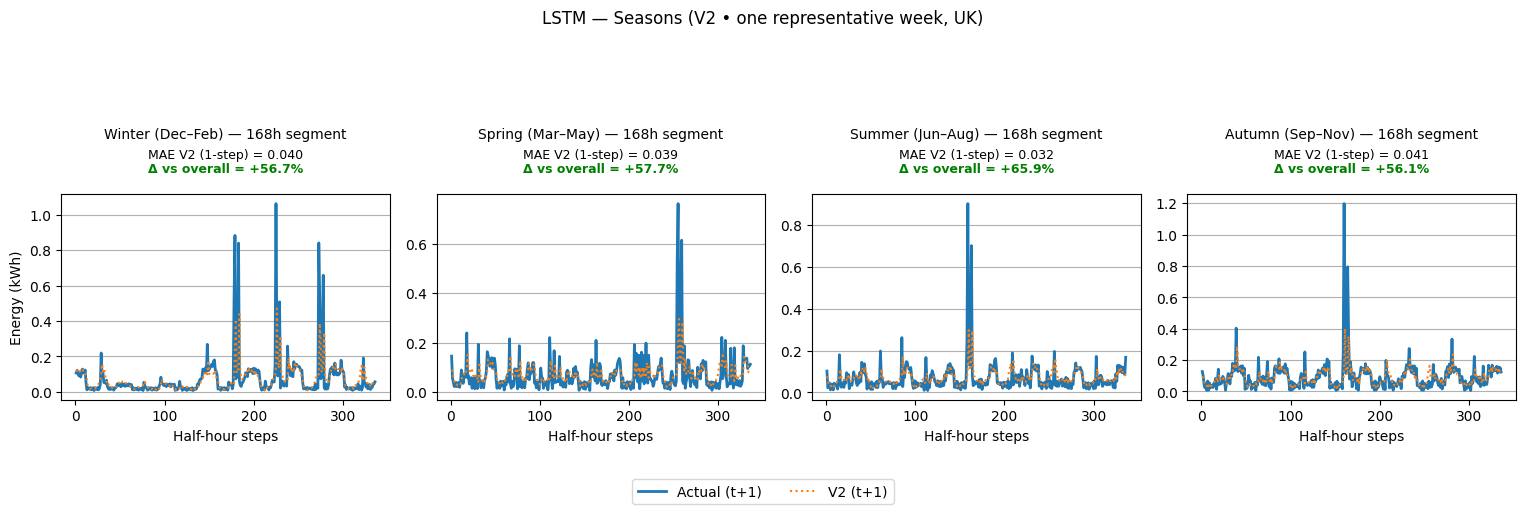

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/seasons_week/LSTM__seasons_V2_week_UK.png


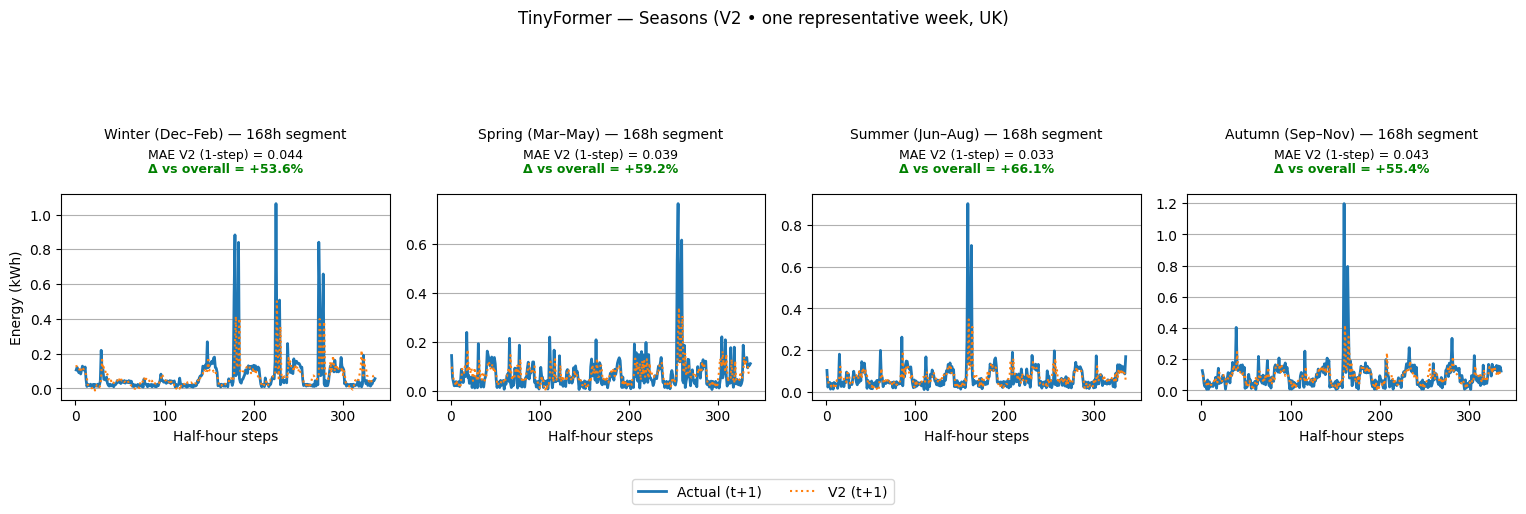

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/seasons_week/TinyFormer__seasons_V2_week_UK.png


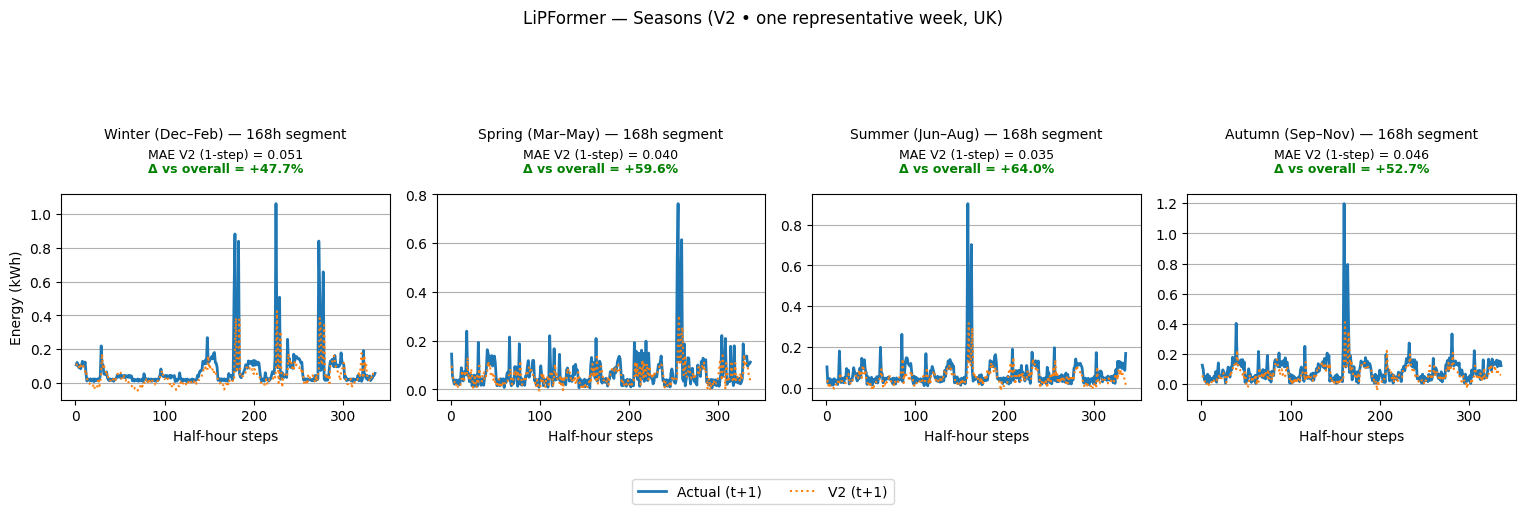

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/seasons_week/LiPFormer__seasons_V2_week_UK.png


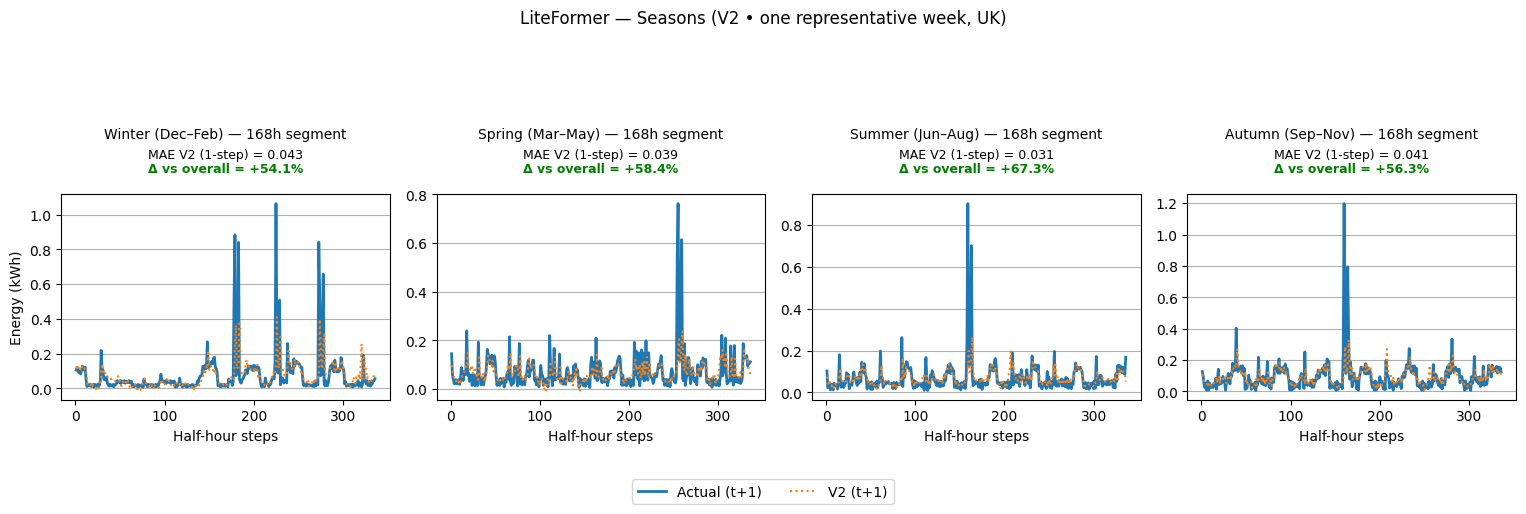

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/seasons_week/LiteFormer__seasons_V2_week_UK.png


In [ ]:
# =========================
# Seasons (UK) • V2-only • ONE REPRESENTATIVE WEEK per season
# Rolling 1-step ahead; Δ vs overall shown (green/red)
# =========================
# Loading arrays
X_v2 = np.load(X_DEMO_PATH).astype(np.float32)
y    = np.load(Y_DEMO_PATH).astype(np.float32)
X_v1 = X_v2[:, :, [V2_CONSUMPTION_COL]]

# Loading models
models_v1 = load_models(V1_MODEL_DIR, V1_BASENAMES)
models_v2 = load_models(V2_MODEL_DIR, V2_BASENAMES)

# Feature index for month at last input step
IX_MONTH = 7

# UK meteorological seasons
SEASON_MAP = {
    "Winter (Dec–Feb)":  [12, 1, 2],
    "Spring (Mar–May)":  [3, 4, 5],
    "Summer (Jun–Aug)":  [6, 7, 8],
    "Autumn (Sep–Nov)":  [9, 10, 11],
}
SEASON_ORDER = ["Winter (Dec–Feb)", "Spring (Mar–May)", "Summer (Jun–Aug)", "Autumn (Sep–Nov)"]

# Helpers
def _predict_batch_first_step(model_obj, X):
    preds = model_obj.predict(X, verbose=0)
    if isinstance(preds, dict):
        arr = np.array(preds.get("output_0", next(iter(preds.values()))))
    else:
        arr = np.array(preds)
    return arr[:, 0].astype(np.float32)

def _overall_first_step_mae(model_obj, X, y_true):
    try:
        pred_first = _predict_batch_first_step(model_obj, X)
    except tf.errors.InternalError:
        with tf.device("/CPU:0"):
            pred_first = _predict_batch_first_step(model_obj, X)
    return float(np.mean(np.abs(y_true[:, 0] - pred_first)))

def _longest_or_target_segment(mask, target_len):
    """
    Find the last segment with length >= target_len; else return the longest True run.
    Returns (start_idx, end_idx_inclusive) or None if no True.
    """
    m = np.asarray(mask, dtype=bool)
    if m.sum() == 0:
        return None
    runs, start = [], None
    for i, val in enumerate(m):
        if val and start is None:
            start = i
        if (not val or i == len(m) - 1) and start is not None:
            end = i if val else i - 1
            runs.append((start, end))
            start = None
    # Prefer the last run meeting target_len
    for st, en in reversed(runs):
        if (en - st + 1) >= target_len:
            return (en - target_len + 1, en)
    # Otherwise longest run
    lengths = [(en - st + 1, st, en) for st, en in runs]
    lengths.sort()
    _, st, en = lengths[-1]
    return (st, en)

# Build season masks from X_v2
months_last = X_v2[:, -1, IX_MONTH].astype(int)
SEASON_MASKS = {name: np.isin(months_last, months) for name, months in SEASON_MAP.items()}

# One representative week (336 half-hours) per season
TARGET_WEEK = 336  # 168 hours

SEASON_DIR = os.path.join(PLOT_DIR_V2, "seasons_week")
os.makedirs(SEASON_DIR, exist_ok=True)

for model_name in ["LSTM","TinyFormer","LiPFormer","LiteFormer"]:
    model_v2 = models_v2[model_name]
    base_mae = _overall_first_step_mae(model_v2, X_v2, y)  # global 1-step baseline

    fig, axes = plt.subplots(1, len(SEASON_ORDER), figsize=(16, 4.8), sharey=False)
    if len(SEASON_ORDER) == 1:
        axes = [axes]

    for j, sname in enumerate(SEASON_ORDER):
        ax = axes[j]
        mask = SEASON_MASKS[sname]
        seg = _longest_or_target_segment(mask, TARGET_WEEK)
        if seg is None:
            ax.set_title(f"{sname} — no data", fontsize=10, color="black")
            ax.axis("off")
            continue

        st, en = seg
        X_seg = X_v2[st:en+1]
        y_seg = y[st:en+1]

        # rolling 1-step predictions for the week
        try:
            pred_first = _predict_batch_first_step(model_v2, X_seg)
        except tf.errors.InternalError:
            with tf.device("/CPU:0"):
                pred_first = _predict_batch_first_step(model_v2, X_seg)

        mae_seg = float(np.mean(np.abs(y_seg[:, 0] - pred_first)))
        delta_pct = ((base_mae - mae_seg) / base_mae) * 100.0 if base_mae > 0 else 0.0
        delta_color = "green" if delta_pct >= 0 else "red"

        h = np.arange(1, len(pred_first) + 1)
        ax.plot(h, y_seg[:, 0], label="Actual (t+1)", linewidth=2)
        ax.plot(h, pred_first, ":", label="V2 (t+1)")

        dur_hours = len(pred_first) / 2.0
        # heading
        ax.set_title(f"{sname} — {dur_hours:.0f}h segment", fontsize=10, color="black", pad=40)
        ax.text(0.5, 1.16, f"MAE V2 (1-step) = {mae_seg:.3f}",
                transform=ax.transAxes, ha="center", va="bottom", fontsize=9, color="black")
        ax.text(0.5, 1.09, f"Δ vs overall = {delta_pct:+.1f}%",
                transform=ax.transAxes, ha="center", va="bottom", fontsize=9, fontweight="bold", color=delta_color)

        ax.set_xlabel("Half-hour steps")
        if j == 0:
            ax.set_ylabel("Energy (kWh)")
        ax.grid(True, axis="y")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="lower center", ncol=2, bbox_to_anchor=(0.5, -0.05))
    fig.suptitle(f"{model_name} — Seasons (V2 • one representative week, UK)", y=0.995, fontsize=12)
    fig.tight_layout(rect=[0.02, 0.06, 0.98, 0.86])

    out_path = os.path.join(SEASON_DIR, f"{model_name}__seasons_V2_week_UK.png")
    fig.savefig(out_path, dpi=220, bbox_inches="tight")
    plt.show(fig)
    plt.close(fig)
    print(f"[OK] Saved: {out_path}")


[OK] Saved Δ% table → /content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final/relative_improvement_V2_vs_V1.csv

        Model  Δ% MAE  Δ% RMSE   Δ% R²
0        LSTM    5.76    -2.01   26.24
1  TinyFormer   25.48    16.96  119.91
2   LiPFormer   22.76    15.82  114.89
3  LiteFormer    5.68    -1.17   27.12


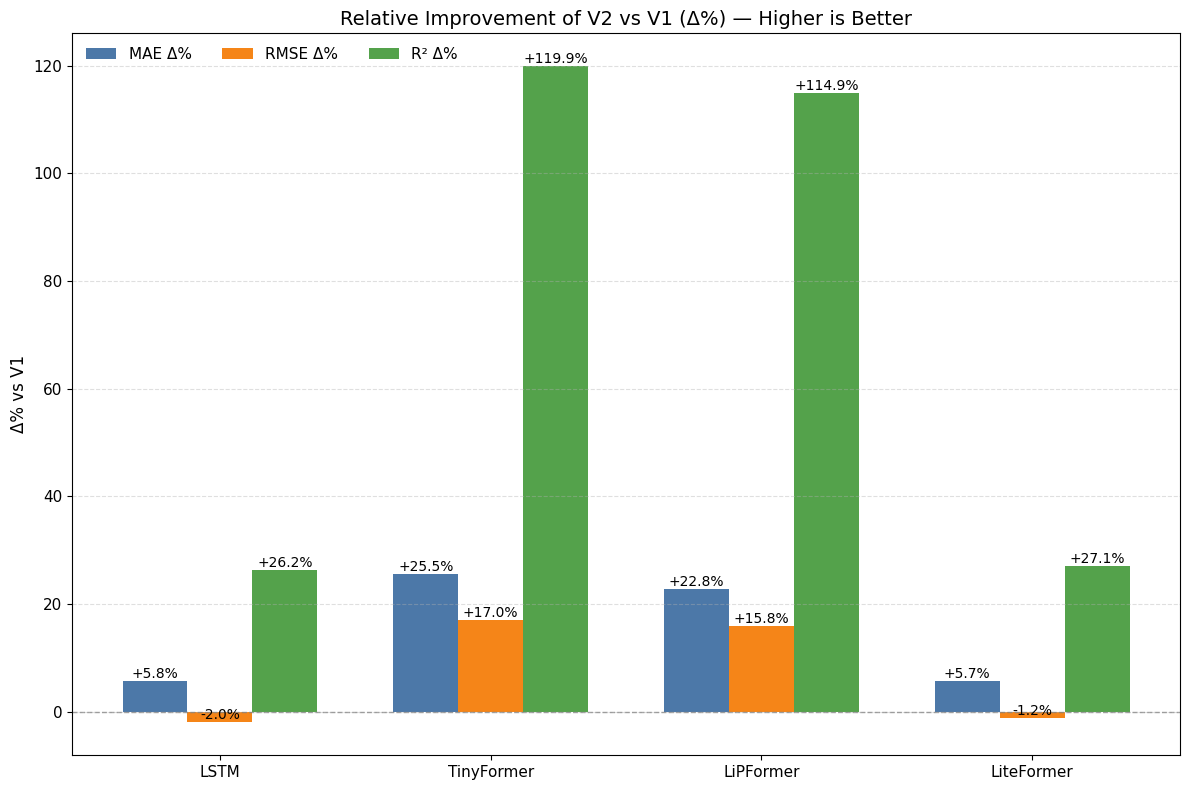

[OK] Saved figure → /content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final/Relative_Improvement_V2_vs_V1.png


In [ ]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ----------------------
# Paths (edit BASE_* if needed)
# ----------------------
BASE_V1 = "/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
BASE_V2 = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
OUT_DIR = "/content/drive/MyDrive/EdgeMeter_AIv2/Model_Comparison_Final"
os.makedirs(OUT_DIR, exist_ok=True)

MODELS = ["LSTM", "TinyFormer", "LiPFormer", "LiteFormer"]
V1_LOGS = {m: os.path.join(BASE_V1, f"{m}_Final_Log.json") for m in MODELS}
V2_LOGS = {m: os.path.join(BASE_V2, f"{m}_Final_Log_48_12.json") for m in MODELS}

# If you're running locally with uploaded files, uncomment:
# V1_LOGS = {
#     "LSTM": "/mnt/data/LSTM_Final_Log.json",
#     "TinyFormer": "/mnt/data/TinyFormer_Final_Log.json",
#     "LiPFormer": "/mnt/data/LiPFormer_Final_Log.json",
#     "LiteFormer": "/mnt/data/LiteFormer_Final_Log.json",
# }
# V2_LOGS = {
#     "LSTM": "/mnt/data/LSTM_Final_Log_48_12.json",
#     "TinyFormer": "/mnt/data/TinyFormer_Final_Log_48_12.json",
#     "LiPFormer": "/mnt/data/LiPFormer_Final_Log_48_12.json",
#     "LiteFormer": "/mnt/data/LiteFormer_Final_Log_48_12.json",
# }

# ----------------------
# Helpers
# ----------------------
def load_json(p):
    with open(p, "r") as f:
        return json.load(f)

def getf(d, *keys, default=np.nan):
    for k in keys:
        v = d.get(k, None)
        if v is not None:
            try:
                return float(v)
            except Exception:
                return np.nan
    return default

def parse_metrics(d):
    # tolerant to test_* or plain keys
    mae  = getf(d, "test_mae", "mae")
    rmse = getf(d, "test_rmse", "rmse")
    r2   = getf(d, "test_r2", "r2")
    return mae, rmse, r2

# ----------------------
# Build metrics table
# ----------------------
rows = []
for m in MODELS:
    v1 = load_json(V1_LOGS[m])
    v2 = load_json(V2_LOGS[m])
    mae1, rmse1, r21 = parse_metrics(v1)
    mae2, rmse2, r22 = parse_metrics(v2)

    d_mae  = ((mae1 - mae2) / mae1) * 100 if (mae1 is not None and mae1 not in [0, np.nan]) else np.nan
    d_rmse = ((rmse1 - rmse2) / rmse1) * 100 if (rmse1 is not None and rmse1 not in [0, np.nan]) else np.nan
    d_r2   = ((r22 - r21) / abs(r21)) * 100 if (r21 is not None and r21 not in [0, np.nan]) else np.nan

    rows.append({"Model": m,
                 "Δ% MAE": d_mae,
                 "Δ% RMSE": d_rmse,
                 "Δ% R²": d_r2})

df_delta = pd.DataFrame(rows)
csv_path = os.path.join(OUT_DIR, "relative_improvement_V2_vs_V1.csv")
df_delta.to_csv(csv_path, index=False)
print(f"[OK] Saved Δ% table → {csv_path}\n")
print(df_delta.round(2))

# ----------------------
# Plot: grouped Δ% bars (one chart)
# ----------------------
plt.rcParams.update({
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

models = df_delta["Model"].to_numpy()
d_mae  = df_delta["Δ% MAE"].to_numpy(dtype=float)
d_rmse = df_delta["Δ% RMSE"].to_numpy(dtype=float)
d_r2   = df_delta["Δ% R²"].to_numpy(dtype=float)

x = np.arange(len(models))
width = 0.24

fig, ax = plt.subplots(figsize=(12, 8))

bars1 = ax.bar(x - width, d_mae,  width, label="MAE Δ%",  color="#4C78A8")  # blue
bars2 = ax.bar(x,         d_rmse, width, label="RMSE Δ%", color="#F58518")  # orange
bars3 = ax.bar(x + width, d_r2,   width, label="R² Δ%",   color="#54A24B")  # green

# 0% reference line
ax.axhline(0, color="grey", linewidth=1, linestyle="--", alpha=0.7)

# Value labels above bars
def annotate(bars):
    for b in bars:
        val = b.get_height()
        if np.isnan(val):
            continue
        ax.text(b.get_x() + b.get_width()/2, val,
                f"{val:+.1f}%", ha="center", va="bottom", fontsize=10)

annotate(bars1); annotate(bars2); annotate(bars3)

ax.set_title("Relative Improvement of V2 vs V1 (Δ%) — Higher is Better")
ax.set_ylabel("Δ% vs V1")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.grid(axis="y", linestyle="--", alpha=0.4)
ax.legend(frameon=False, ncol=3, loc="upper left")

fig.tight_layout()
out_path = os.path.join(OUT_DIR, "Relative_Improvement_V2_vs_V1.png")
fig.savefig(out_path, dpi=240, bbox_inches="tight")
plt.show()
print(f"[OK] Saved figure → {out_path}")


[OK] Saved figure → /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/V1_V2_Accuracy_Subplots.png


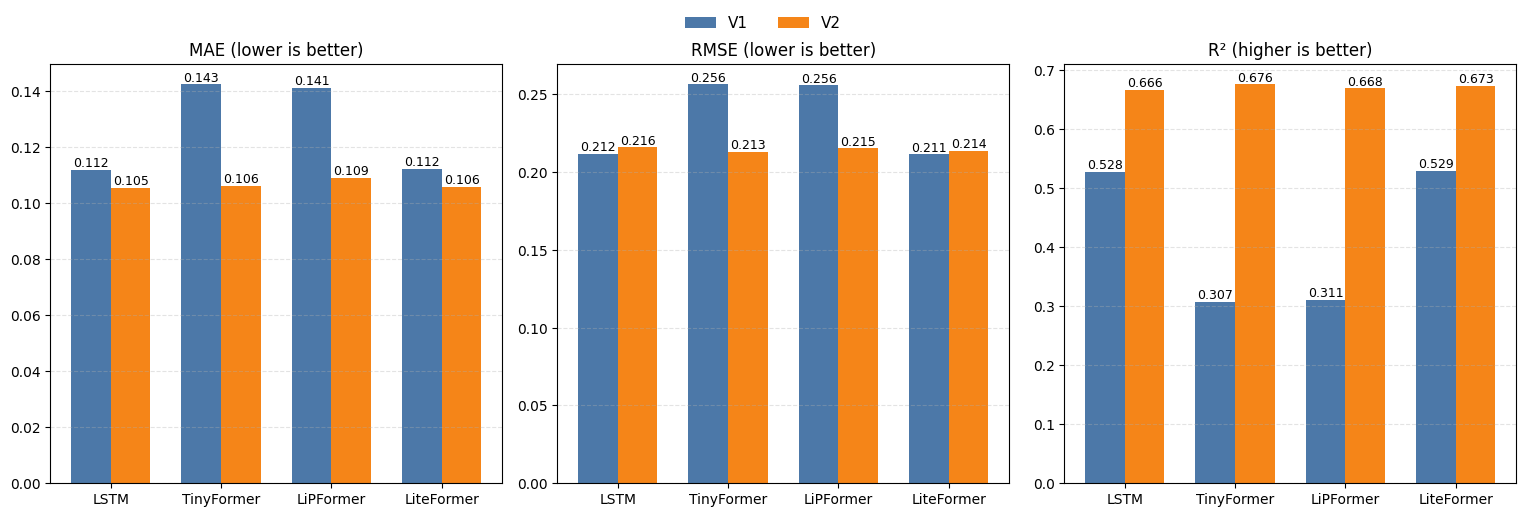

In [ ]:
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ====== Paths (edit if your logs live elsewhere) ======
# Drive locations
BASE_V1 = "/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
BASE_V2 = "/content/drive/MyDrive/EdgeMeter_AIv2/data"

V1_LOGS = {
    "LSTM":       os.path.join(BASE_V1, "LSTM_Final_Log.json"),
    "TinyFormer": os.path.join(BASE_V1, "TinyFormer_Final_Log.json"),
    "LiPFormer":  os.path.join(BASE_V1, "LiPFormer_Final_Log.json"),
    "LiteFormer": os.path.join(BASE_V1, "LiteFormer_Final_Log.json"),
}
V2_LOGS = {
    "LSTM":       os.path.join(BASE_V2, "LSTM_Final_Log_48_12.json"),
    "TinyFormer": os.path.join(BASE_V2, "TinyFormer_Final_Log_48_12.json"),
    "LiPFormer":  os.path.join(BASE_V2, "LiPFormer_Final_Log_48_12.json"),
    "LiteFormer": os.path.join(BASE_V2, "LiteFormer_Final_Log_48_12.json"),
}

MODELS = ["LSTM", "TinyFormer", "LiPFormer", "LiteFormer"]

# ====== Helpers ======
def load_json(p):
    with open(p, "r") as f:
        return json.load(f)

def getf(d, *keys):
    """Return first present numeric key, else NaN."""
    for k in keys:
        if k in d and d[k] is not None:
            try:
                return float(d[k])
            except Exception:
                pass
    return np.nan

def parse_core(d):
    # tolerant to test_* or plain keys
    return dict(
        mae  = getf(d, "test_mae", "mae"),
        rmse = getf(d, "test_rmse", "rmse"),
        r2   = getf(d, "test_r2", "r2"),
    )

# ====== Load metrics from logs ======
rows = []
for m in MODELS:
    v1 = parse_core(load_json(V1_LOGS[m]))
    v2 = parse_core(load_json(V2_LOGS[m]))
    rows.append({
        "Model":  m,
        "MAE_V1": v1["mae"],   "MAE_V2": v2["mae"],
        "RMSE_V1": v1["rmse"], "RMSE_V2": v2["rmse"],
        "R2_V1": v1["r2"],     "R2_V2": v2["r2"],
    })
df = pd.DataFrame(rows)

# ====== Plot: one figure, 3 subplots (MAE, RMSE, R²) ======
plt.rcParams.update({
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11
})

fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=False)

metrics = [
    ("MAE_V1",  "MAE_V2",  "MAE (lower is better)"),
    ("RMSE_V1", "RMSE_V2", "RMSE (lower is better)"),
    ("R2_V1",   "R2_V2",   "R² (higher is better)"),
]
colors = {"V1": "#4C78A8", "V2": "#F58518"}  # blue/orange, colorblind-friendly
x = np.arange(len(MODELS))
width = 0.36

for ax, (col1, col2, title) in zip(axes, metrics):
    v1_vals = df[col1].to_numpy(dtype=float)
    v2_vals = df[col2].to_numpy(dtype=float)

    b1 = ax.bar(x - width/2, v1_vals, width, label="V1", color=colors["V1"])
    b2 = ax.bar(x + width/2, v2_vals, width, label="V2", color=colors["V2"])

    # annotate values above bars
    def annotate(bars):
        for b in bars:
            val = b.get_height()
            if np.isnan(val):
                continue
            ax.text(b.get_x() + b.get_width()/2, val, f"{val:.3f}",
                    ha="center", va="bottom", fontsize=9)
    annotate(b1); annotate(b2)

    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(MODELS)
    ax.grid(axis="y", linestyle="--", alpha=0.35)

# shared legend on top
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.04))

fig.tight_layout(rect=[0.02, 0.0, 0.98, 0.99])

# Save to Drive
OUT_DIR = os.path.join(BASE_V2, "Model_Comparison_Final")
os.makedirs(OUT_DIR, exist_ok=True)
save_path = os.path.join(OUT_DIR, "V1_V2_Accuracy_Subplots.png")
fig.savefig(save_path, dpi=240, bbox_inches="tight")
print(f"[OK] Saved figure → {save_path}")


In [ ]:
# --- Build paper-ready summary table ---
import numpy as np, pandas as pd, os, json

BASE_V1 = "/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
BASE_V2 = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
OUT_DIR = os.path.join(BASE_V2, "Model_Comparison_Final")
os.makedirs(OUT_DIR, exist_ok=True)

MODELS = ["LSTM","TinyFormer","LiPFormer","LiteFormer"]
V1_LOGS = {m: os.path.join(BASE_V1, f"{m}_Final_Log.json") for m in MODELS}
V2_LOGS = {m: os.path.join(BASE_V2, f"{m}_Final_Log_48_12.json") for m in MODELS}

def load_json_safely(p):
    try:
        with open(p, "r") as f: return json.load(f)
    except Exception as e:
        print(f"[warn] failed to read {p}: {e}")
        return {}

def getf(d, *keys):
    for k in keys:
        if k in d and d[k] is not None:
            try: return float(d[k])
            except: pass
    return np.nan

def parse_core(d):
    return dict(
        MAE=getf(d,"test_mae","mae"),
        RMSE=getf(d,"test_rmse","rmse"),
        R2=getf(d,"test_r2","r2"),
    )

rows = []
for m in MODELS:
    v1 = parse_core(load_json_safely(V1_LOGS[m]))
    v2 = parse_core(load_json_safely(V2_LOGS[m]))
    d = {
        "Model": m,
        "MAE_V1": v1["MAE"], "MAE_V2": v2["MAE"],
        "RMSE_V1": v1["RMSE"], "RMSE_V2": v2["RMSE"],
        "R2_V1": v1["R2"], "R2_V2": v2["R2"],
    }
    # relative deltas (positive is better)
    d["Δ% MAE"]  = ((d["MAE_V1"]  - d["MAE_V2"])  / d["MAE_V1"])*100 if np.isfinite(d["MAE_V1"]) else np.nan
    d["Δ% RMSE"] = ((d["RMSE_V1"] - d["RMSE_V2"]) / d["RMSE_V1"])*100 if np.isfinite(d["RMSE_V1"]) else np.nan
    d["Δ% R²"]   = ((d["R2_V2"]   - d["R2_V1"])   / abs(d["R2_V1"]))*100 if np.isfinite(d["R2_V1"]) and d["R2_V1"]!=0 else np.nan
    rows.append(d)

df = pd.DataFrame(rows, columns=[
    "Model",
    "MAE_V1","MAE_V2","Δ% MAE",
    "RMSE_V1","RMSE_V2","Δ% RMSE",
    "R2_V1","R2_V2","Δ% R²",
]).round(4)

csv_path = os.path.join(OUT_DIR, "metrics_summary.csv")
df.to_csv(csv_path, index=False)
print(f"[OK] metrics summary → {csv_path}")
display(df)


[OK] metrics summary → /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/metrics_summary.csv


,Model,MAE_V1,MAE_V2,Δ% MAE,RMSE_V1,RMSE_V2,Δ% RMSE,R2_V1,R2_V2,Δ% R²
0,LSTM,0.1119,0.1054,5.7601,0.2118,0.2160,-2.0125,0.5277,0.6662,26.2393
1,TinyFormer,0.1425,0.1062,25.4755,0.2565,0.2130,16.9578,0.3072,0.6755,119.9131
2,LiPFormer,0.1412,0.1091,22.7595,0.2558,0.2153,15.8173,0.3110,0.6684,114.8942
3,LiteFormer,0.1122,0.1058,5.6828,0.2114,0.2139,-1.1717,0.5292,0.6727,27.1210


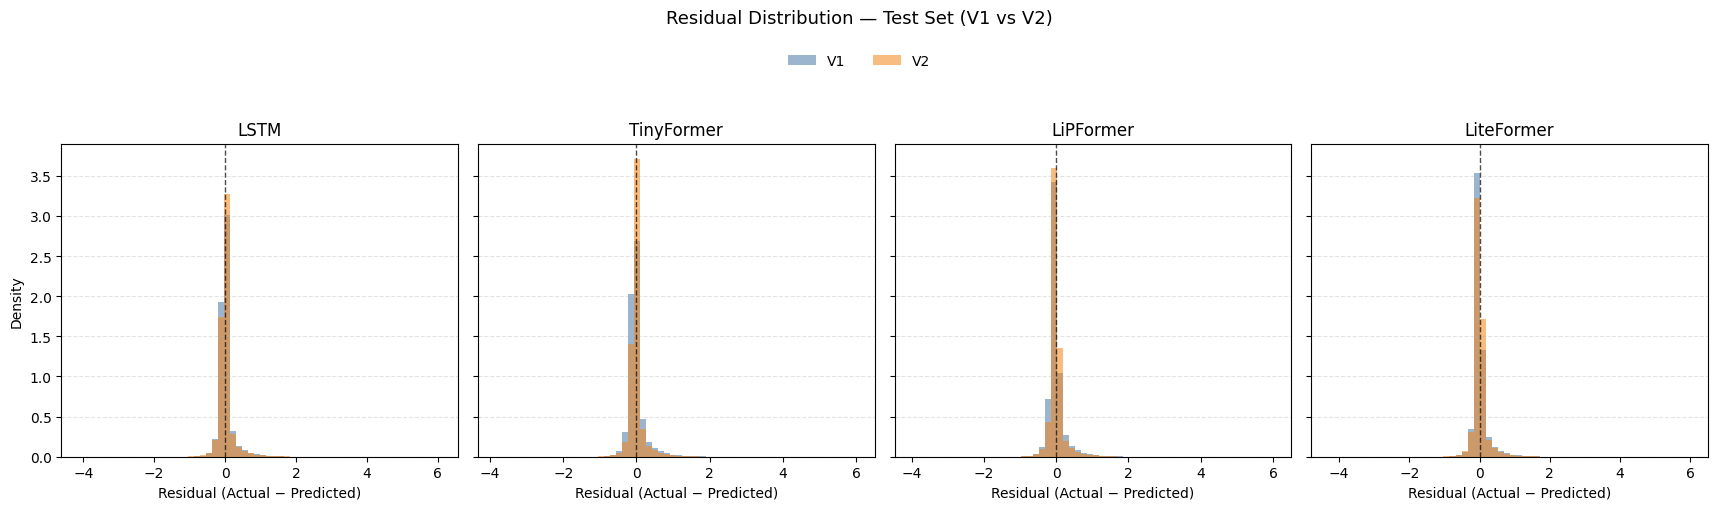

[OK] saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Test_Residual_Hist_V1_vs_V2.png


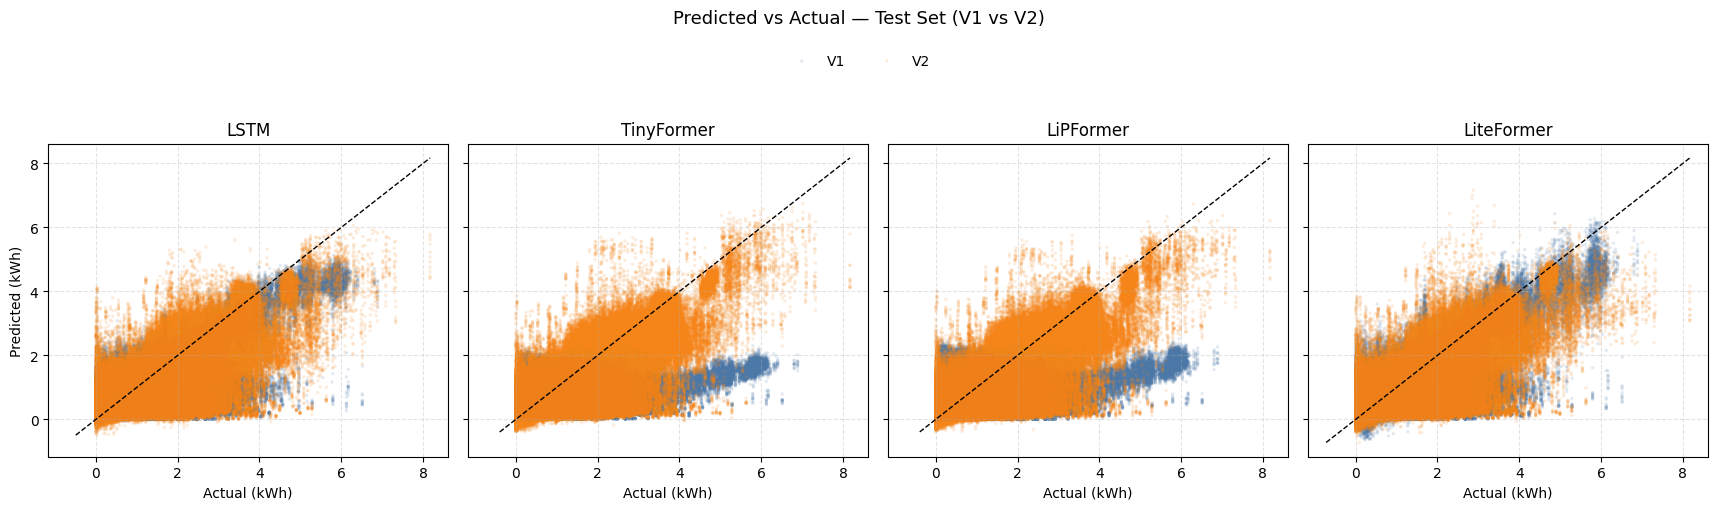

[OK] saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Test_Scatter_Pred_vs_Actual_V1_vs_V2.png


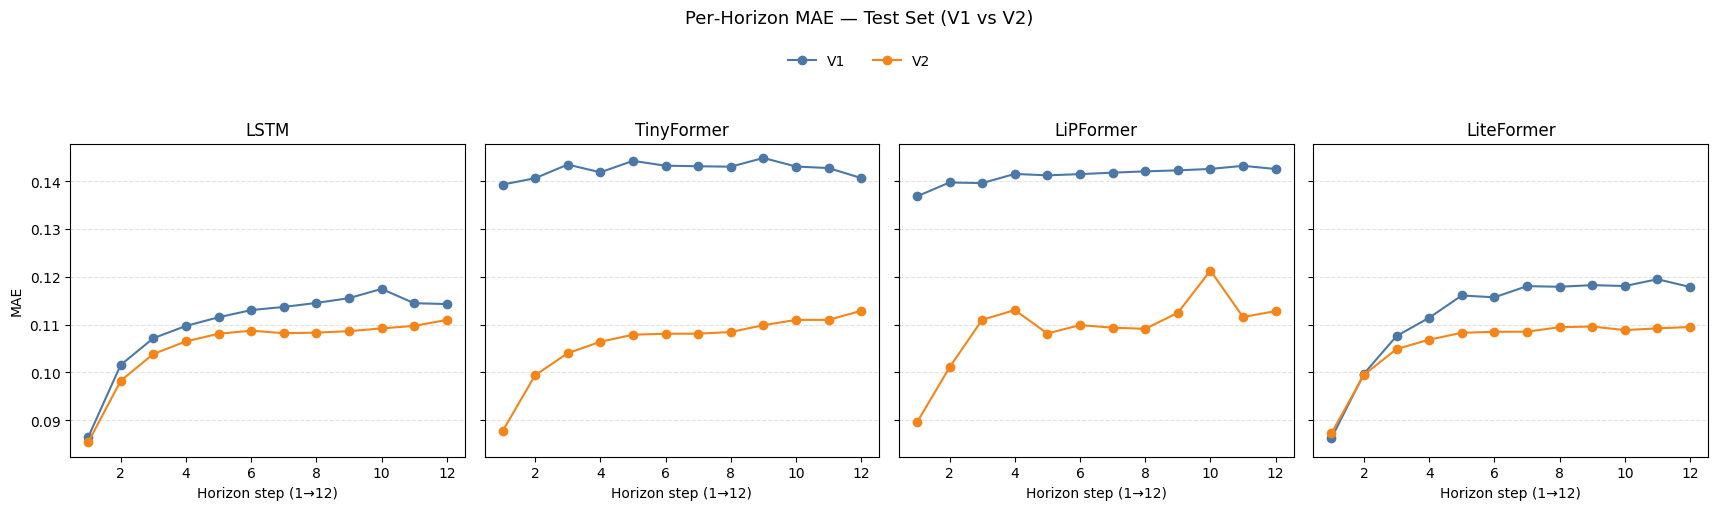

[OK] saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Test_Horizon_MAE_V1_vs_V2.png


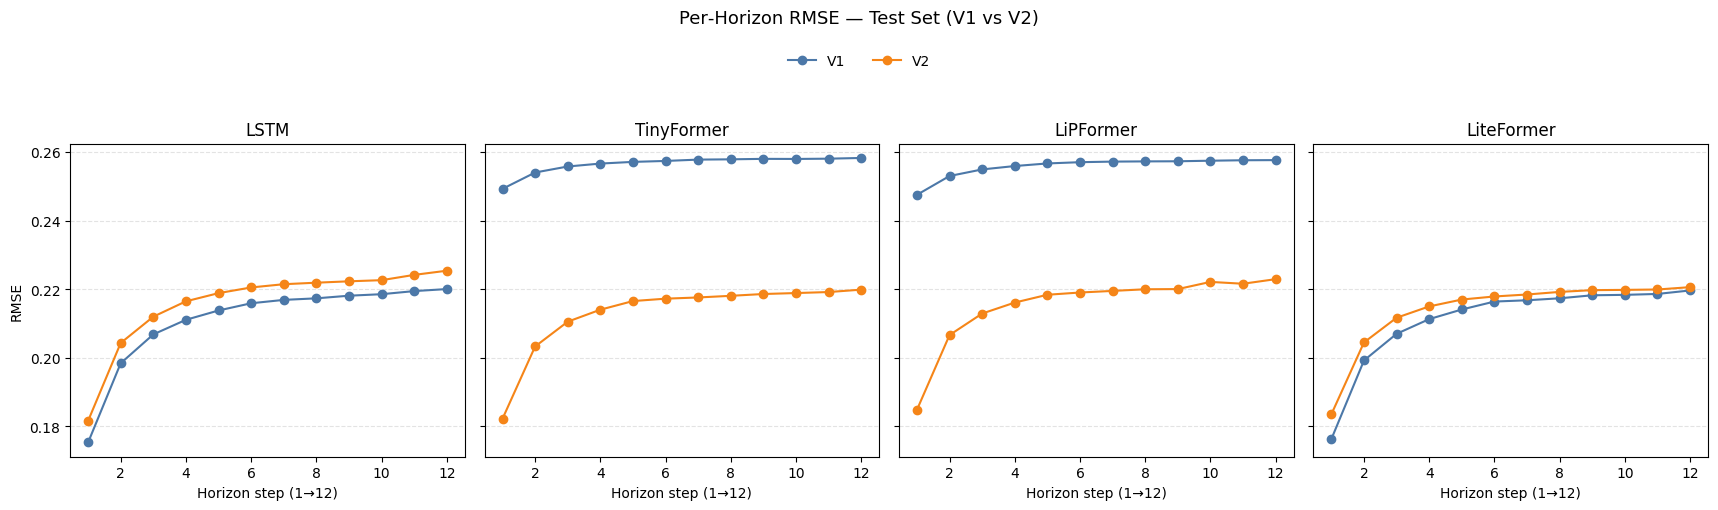

[OK] saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Test_Horizon_RMSE_V1_vs_V2.png

[DONE] Saved all plots to: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# =========================
# Required paths (as provided)
# =========================
V1_DIR = "/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
V2_DIR = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
OUT_DIR = "/content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final"
os.makedirs(OUT_DIR, exist_ok=True)

MODELS = ["LSTM", "TinyFormer", "LiPFormer", "LiteFormer"]

# =========================
# Helpers: robust file loaders
# =========================
def _load_npy(path, label):
    if not os.path.exists(path):
        raise FileNotFoundError(f"Missing {label}: {path}")
    return np.load(path)

def _load_array_csv_or_npy(path_csv, path_npy, label, like=None):
    """
    Try CSV first, then NPY. Optionally validate shape with 'like'.
    Returns float ndarray.
    """
    arr = None
    if os.path.exists(path_csv):
        arr = pd.read_csv(path_csv, header=None).values.astype(float)
    elif os.path.exists(path_npy):
        arr = np.load(path_npy).astype(float)
    else:
        raise FileNotFoundError(f"Missing {label}: {path_csv} or {path_npy}")

    if like is not None and arr.shape != like.shape:
        raise ValueError(f"Shape mismatch for {label}: got {arr.shape} vs expected {like.shape}")
    return arr

def mae(y, p):
    return float(np.mean(np.abs(y - p)))

def rmse(y, p):
    return float(np.sqrt(np.mean((y - p) ** 2)))

# =========================
# Load test sets and predictions for both versions
# =========================
# V1
y1 = _load_npy(os.path.join(V1_DIR, "y_test.npy"), "V1 y_test").astype(float)
pred1 = {}
for m in MODELS:
    pred1[m] = _load_array_csv_or_npy(
        os.path.join(V1_DIR, f"{m}_y_pred.csv"),
        os.path.join(V1_DIR, f"{m}_y_pred.npy"),
        f"V1 {m} predictions",
        like=y1
    )

# V2 (note the _48_12 suffix)
y2 = _load_npy(os.path.join(V2_DIR, "y_test_48_12.npy"), "V2 y_test").astype(float)
pred2 = {}
for m in MODELS:
    pred2[m] = _load_array_csv_or_npy(
        os.path.join(V2_DIR, f"{m}_y_pred_48_12.csv"),
        os.path.join(V2_DIR, f"{m}_y_pred_48_12.npy"),
        f"V2 {m} predictions",
        like=y2
    )

# =========================
# 1) Residual Distribution & Histogram (one figure, all models)
# =========================
fig, axes = plt.subplots(1, 4, figsize=(18, 4.6), sharey=True)
bins = 60
for i, m in enumerate(MODELS):
    ax = axes[i]
    r1 = (y1 - pred1[m]).reshape(-1)
    r2 = (y2 - pred2[m]).reshape(-1)
    # global bin edges per subplot for comparability
    rmin = np.nanmin([r1.min(), r2.min()])
    rmax = np.nanmax([r1.max(), r2.max()])
    edges = np.linspace(rmin, rmax, bins + 1)

    ax.hist(r1, bins=edges, alpha=0.55, density=True, label="V1", color="#4C78A8")
    ax.hist(r2, bins=edges, alpha=0.55, density=True, label="V2", color="#F58518")
    ax.axvline(0, color="k", lw=1, ls="--", alpha=0.7)
    ax.set_title(m)
    ax.set_xlabel("Residual (Actual − Predicted)")
    if i == 0:
        ax.set_ylabel("Density")
    ax.grid(axis="y", linestyle="--", alpha=0.35)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))
fig.suptitle("Residual Distribution — Test Set (V1 vs V2)", y=1.12, fontsize=13)
fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
path = os.path.join(OUT_DIR, "Test_Residual_Hist_V1_vs_V2.png")
fig.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print("[OK] saved:", path)

# =========================
# 2) Predicted vs Actual Scatter (one figure, all models)
# =========================
fig, axes = plt.subplots(1, 4, figsize=(18, 4.6), sharex=True, sharey=True)
for i, m in enumerate(MODELS):
    ax = axes[i]
    a1, p1 = y1.reshape(-1), pred1[m].reshape(-1)
    a2, p2 = y2.reshape(-1), pred2[m].reshape(-1)

    # Combined limits for fair y=x line
    lo = min(a1.min(), p1.min(), a2.min(), p2.min())
    hi = max(a1.max(), p1.max(), a2.max(), p2.max())

    ax.scatter(a1, p1, s=6, alpha=0.15, label="V1", color="#4C78A8", edgecolors="none")
    ax.scatter(a2, p2, s=6, alpha=0.15, label="V2", color="#F58518", edgecolors="none")
    ax.plot([lo, hi], [lo, hi], "k--", lw=1)

    ax.set_title(m)
    ax.set_xlabel("Actual (kWh)")
    if i == 0:
        ax.set_ylabel("Predicted (kWh)")
    ax.grid(True, linestyle="--", alpha=0.35)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))
fig.suptitle("Predicted vs Actual — Test Set (V1 vs V2)", y=1.12, fontsize=13)
fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
path = os.path.join(OUT_DIR, "Test_Scatter_Pred_vs_Actual_V1_vs_V2.png")
fig.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print("[OK] saved:", path)

# =========================
# 3) Per‑Horizon Accuracy Profile (MAE and RMSE)
# =========================
def horizon_metric(y, p, fn):
    # y, p: (N, 12) -> returns (12,)
    H = y.shape[1]
    vals = np.zeros(H, dtype=float)
    for h in range(H):
        vals[h] = fn(y[:, h], p[:, h])
    return vals

# MAE panel (V1 vs V2 lines per model)
fig, axes = plt.subplots(1, 4, figsize=(18, 4.6), sharey=True)
for i, m in enumerate(MODELS):
    ax = axes[i]
    mae1 = horizon_metric(y1, pred1[m], lambda a,b: np.mean(np.abs(a-b)))
    mae2 = horizon_metric(y2, pred2[m], lambda a,b: np.mean(np.abs(a-b)))
    h = np.arange(1, len(mae1)+1)
    ax.plot(h, mae1, marker="o", label="V1", color="#4C78A8")
    ax.plot(h, mae2, marker="o", label="V2", color="#F58518")
    ax.set_title(m)
    ax.set_xlabel("Horizon step (1→12)")
    if i == 0:
        ax.set_ylabel("MAE")
    ax.grid(axis="y", linestyle="--", alpha=0.35)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))
fig.suptitle("Per‑Horizon MAE — Test Set (V1 vs V2)", y=1.12, fontsize=13)
fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
path = os.path.join(OUT_DIR, "Test_Horizon_MAE_V1_vs_V2.png")
fig.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print("[OK] saved:", path)

# RMSE panel (V1 vs V2 lines per model)
fig, axes = plt.subplots(1, 4, figsize=(18, 4.6), sharey=True)
for i, m in enumerate(MODELS):
    ax = axes[i]
    rmse1 = horizon_metric(y1, pred1[m], lambda a,b: np.sqrt(np.mean((a-b)**2)))
    rmse2 = horizon_metric(y2, pred2[m], lambda a,b: np.sqrt(np.mean((a-b)**2)))
    h = np.arange(1, len(rmse1)+1)
    ax.plot(h, rmse1, marker="o", label="V1", color="#4C78A8")
    ax.plot(h, rmse2, marker="o", label="V2", color="#F58518")
    ax.set_title(m)
    ax.set_xlabel("Horizon step (1→12)")
    if i == 0:
        ax.set_ylabel("RMSE")
    ax.grid(axis="y", linestyle="--", alpha=0.35)

handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", ncol=2, frameon=False, bbox_to_anchor=(0.5, 1.05))
fig.suptitle("Per‑Horizon RMSE — Test Set (V1 vs V2)", y=1.12, fontsize=13)
fig.tight_layout(rect=[0.02, 0.02, 0.98, 0.98])
path = os.path.join(OUT_DIR, "Test_Horizon_RMSE_V1_vs_V2.png")
fig.savefig(path, dpi=300, bbox_inches="tight")
plt.show()
print("[OK] saved:", path)

print("\n[DONE] Saved all plots to:", OUT_DIR)


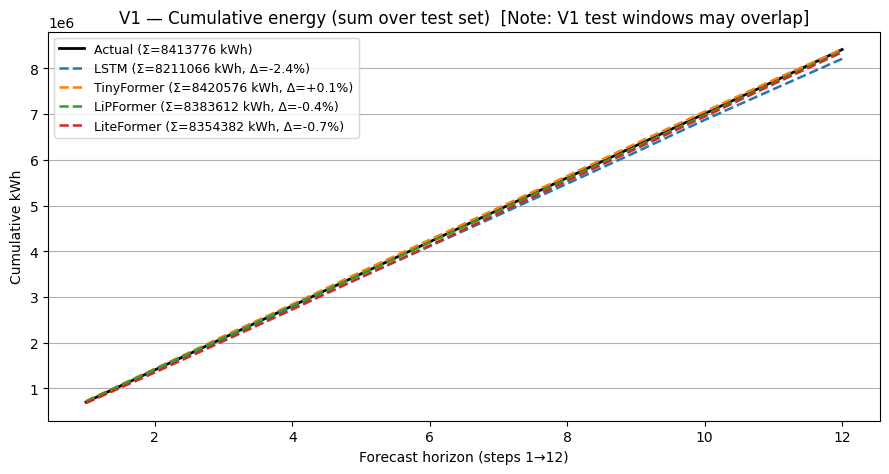

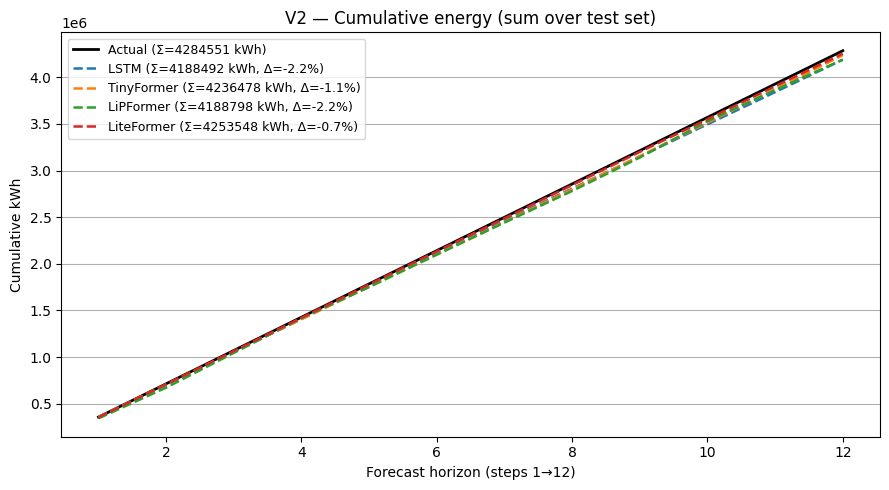

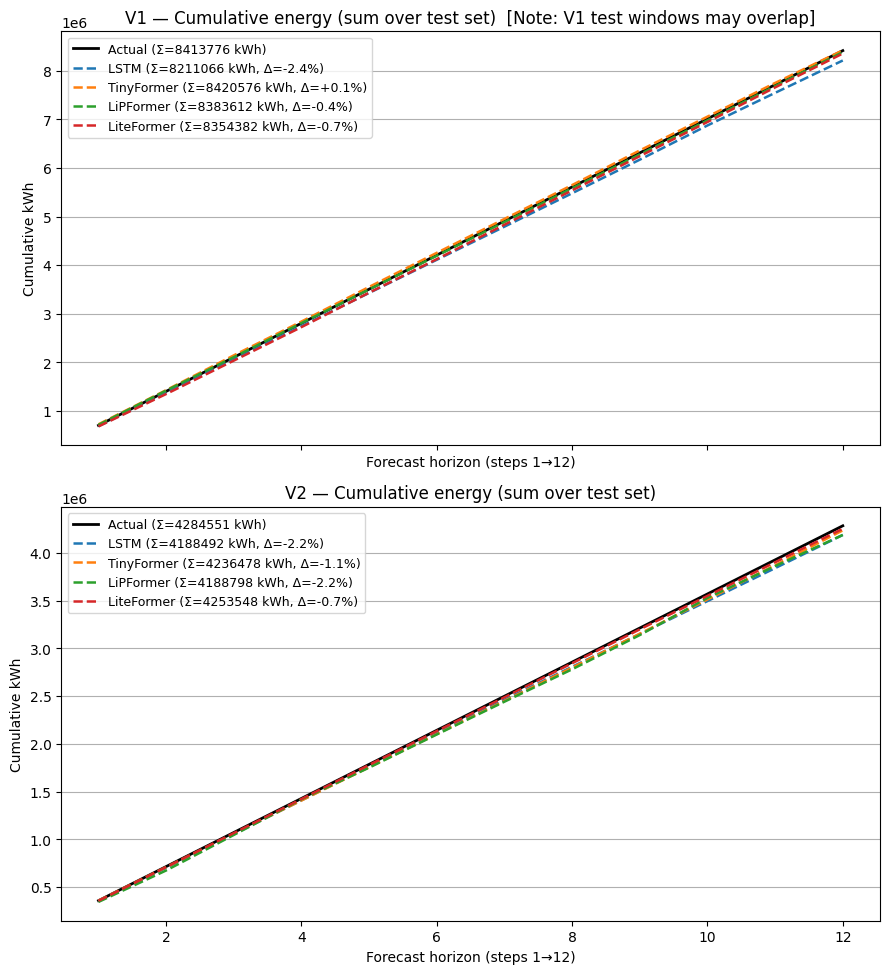

[OK] Saved:
 - /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Cumulative_KPI_V1.png
 - /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Cumulative_KPI_V2.png
 - /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Cumulative_KPI_V1_V2_STACKED.png


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---- Paths ----
V1_DIR = "/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
V2_DIR = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
OUT_DIR = "/content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final"
os.makedirs(OUT_DIR, exist_ok=True)

MODELS = ["LSTM", "TinyFormer", "LiPFormer", "LiteFormer"]

# Expected filenames
V1_YTEST = os.path.join(V1_DIR, "y_test.npy")
V2_YTEST = os.path.join(V2_DIR, "y_test_48_12.npy")

def load_y_test(path):
    if not os.path.exists(path):
        raise FileNotFoundError(f"y_test not found: {path}")
    arr = np.load(path).astype(np.float32)
    if arr.ndim != 2 or arr.shape[1] != 12:
        raise ValueError(f"y_test must be (N,12), got {arr.shape}")
    return arr

def load_pred_csv(path):
    if not os.path.exists(path):
        raise FileNotFoundError(path)
    df = pd.read_csv(path, header=None)
    arr = df.values.astype(np.float32)
    if arr.ndim != 2 or arr.shape[1] != 12:
        raise ValueError(f"pred CSV must be (N,12), got {arr.shape} at {path}")
    return arr

def cumulative_curve(y_2d):
    # y_2d: (N,12) -> per-step totals (length 12) -> cumulative across horizon
    per_step_totals = y_2d.sum(axis=0)           # shape (12,)
    return np.cumsum(per_step_totals)            # shape (12,)

def plot_version(ax, y_true, preds_dict, version_label, note_overlap=False):
    h = np.arange(1, 13)
    actual_curve = cumulative_curve(y_true)
    total_actual = float(actual_curve[-1])

    ax.plot(h, actual_curve, label=f"Actual (Σ={total_actual:.0f} kWh)", linewidth=2, color='black')

    # consistent colors
    colors = {
        "LSTM": "#1f77b4",
        "TinyFormer": "#ff7f0e",
        "LiPFormer": "#2ca02c",
        "LiteFormer": "#d62728",
    }

    for m in MODELS:
        if m not in preds_dict:
            continue
        pred_curve = cumulative_curve(preds_dict[m])
        total_pred = float(pred_curve[-1])
        delta_pct = (total_pred - total_actual) / (total_actual + 1e-8) * 100.0
        ax.plot(h, pred_curve, label=f"{m} (Σ={total_pred:.0f} kWh, Δ={delta_pct:+.1f}%)",
                linewidth=1.8, linestyle='--', color=colors.get(m, None))

    ax.set_xlabel("Forecast horizon (steps 1→12)")
    ax.set_ylabel("Cumulative kWh")
    title = f"{version_label} — Cumulative energy (sum over test set)"
    if note_overlap:
        title += "  [Note: V1 test windows may overlap]"
    ax.set_title(title)
    ax.grid(True, axis="y")
    ax.legend(loc="upper left", fontsize=9)

# ---- Load data ----
y_v1 = load_y_test(V1_YTEST)
y_v2 = load_y_test(V2_YTEST)

# Load predictions for each version
preds_v1 = {}
preds_v2 = {}
for m in MODELS:
    # V1: {model}_y_pred.csv
    p1 = os.path.join(V1_DIR, f"{m}_y_pred.csv")
    try:
        preds_v1[m] = load_pred_csv(p1)
    except Exception as e:
        print(f"[warn] skipping V1 {m}: {e}")

    # V2: {model}_y_pred_48_12.csv
    p2 = os.path.join(V2_DIR, f"{m}_y_pred_48_12.csv")
    try:
        preds_v2[m] = load_pred_csv(p2)
    except Exception as e:
        print(f"[warn] skipping V2 {m}: {e}")

# Basic shape sanity
for m, arr in preds_v1.items():
    if arr.shape != y_v1.shape:
        print(f"[warn] shape mismatch V1 {m}: pred {arr.shape} vs y {y_v1.shape}")
for m, arr in preds_v2.items():
    if arr.shape != y_v2.shape:
        print(f"[warn] shape mismatch V2 {m}: pred {arr.shape} vs y {y_v2.shape}")

# ---- Individual figures per version ----
fig1, ax1 = plt.subplots(figsize=(9, 5))
plot_version(ax1, y_v1, preds_v1, "V1", note_overlap=True)
fig1.tight_layout()
out_v1 = os.path.join(OUT_DIR, "Cumulative_KPI_V1.png")
fig1.savefig(out_v1, dpi=220, bbox_inches="tight")
plt.show()

fig2, ax2 = plt.subplots(figsize=(9, 5))
plot_version(ax2, y_v2, preds_v2, "V2", note_overlap=False)
fig2.tight_layout()
out_v2 = os.path.join(OUT_DIR, "Cumulative_KPI_V2.png")
fig2.savefig(out_v2, dpi=220, bbox_inches="tight")
plt.show()

# ---- Combined figure (two subplots stacked) ----
fig3, (ax_top, ax_bot) = plt.subplots(2, 1, figsize=(9, 10), sharex=True)
plot_version(ax_top, y_v1, preds_v1, "V1", note_overlap=True)
plot_version(ax_bot, y_v2, preds_v2, "V2", note_overlap=False)
fig3.tight_layout()
out_both = os.path.join(OUT_DIR, "Cumulative_KPI_V1_V2_STACKED.png")
fig3.savefig(out_both, dpi=220, bbox_inches="tight")
plt.show()

print(f"[OK] Saved:\n - {out_v1}\n - {out_v2}\n - {out_both}")


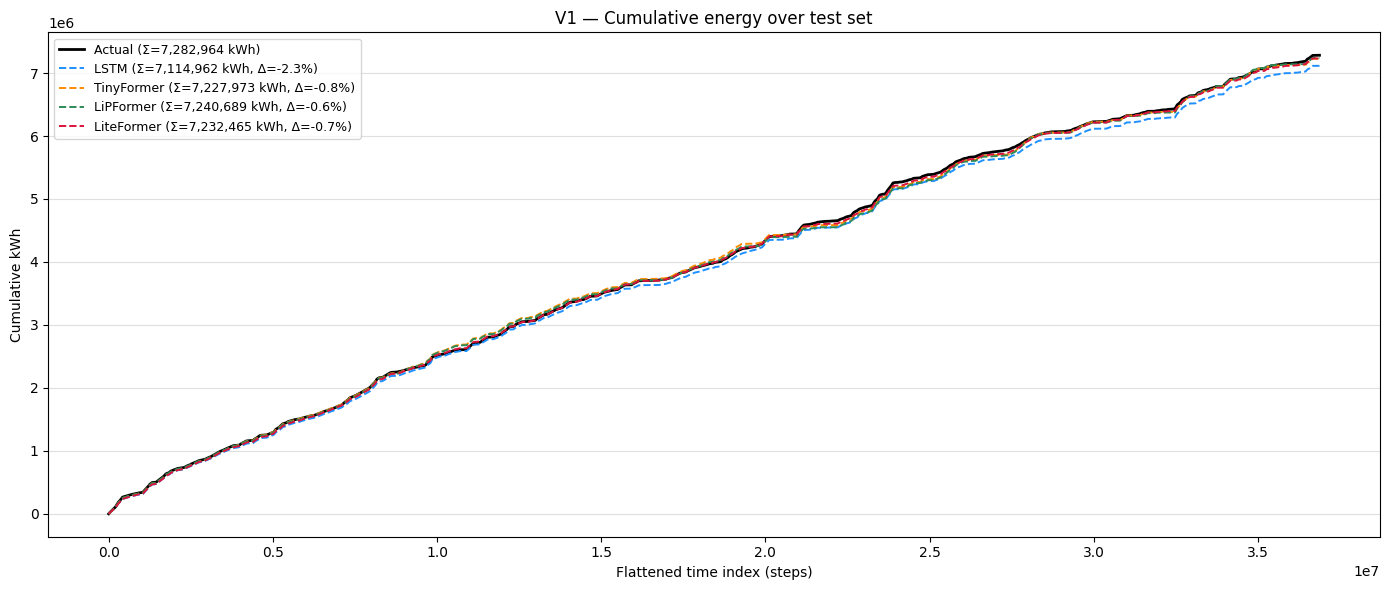

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Cumulative_V1.png


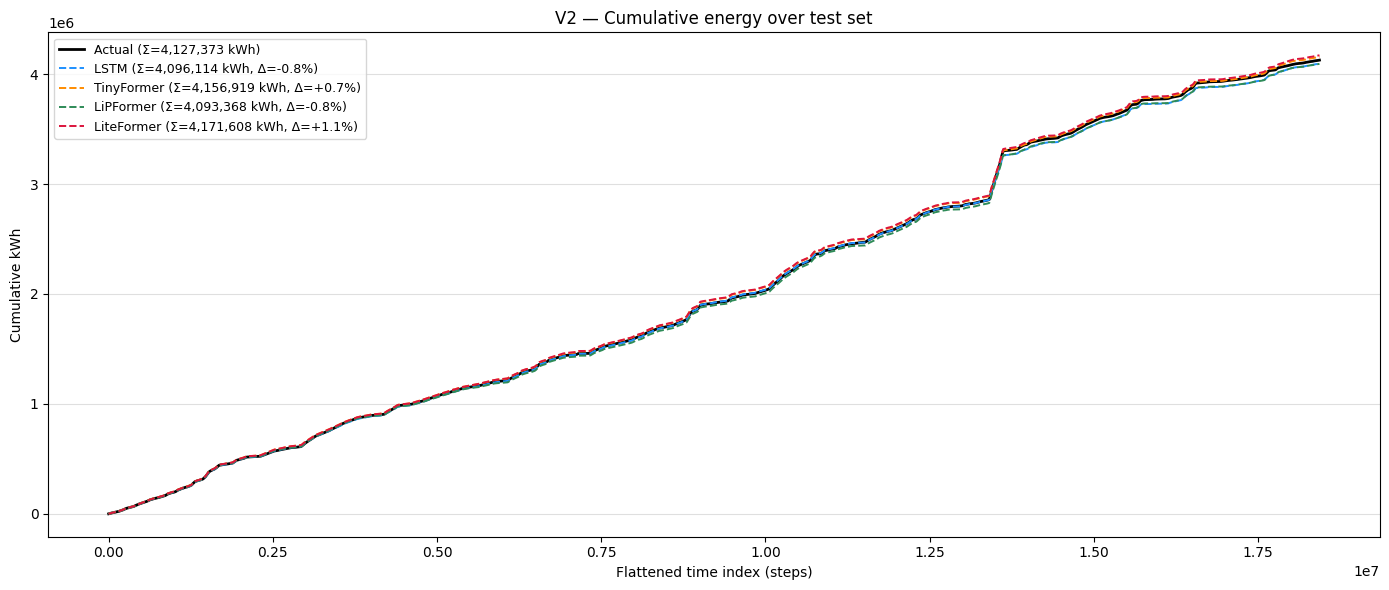

[OK] Saved: /content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final/Cumulative_V2.png


In [8]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# -------------------
# Paths & models
# -------------------
V1_DIR  = "/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
V2_DIR  = "/content/drive/MyDrive/EdgeMeter_AIv2/data"
OUT_DIR = "/content/drive/MyDrive/EdgeMeter_AIv2/data/Model_Comparison_Final"
os.makedirs(OUT_DIR, exist_ok=True)

MODELS = ["LSTM", "TinyFormer", "LiPFormer", "LiteFormer"]
COLORS = {
    "Actual":     "black",
    "LSTM":       "dodgerblue",
    "TinyFormer": "darkorange",
    "LiPFormer":  "seagreen",
    "LiteFormer": "crimson",
}

# -------------------
# Loaders
# -------------------
def load_version(vdir, version):
    if version == "V1":
        y_file = "y_test.npy"
        pred_fmt = "{}_y_pred.csv"
    else:
        y_file = "y_test_48_12.npy"
        pred_fmt = "{}_y_pred_48_12.csv"

    y = np.load(os.path.join(vdir, y_file)).astype(np.float32).reshape(-1)
    preds = {}
    for m in MODELS:
        p_path = os.path.join(vdir, pred_fmt.format(m))
        arr = pd.read_csv(p_path, header=None).values.astype(np.float32).reshape(-1)
        preds[m] = arr
    return y, preds

# -------------------
# Plot cumulative kWh
# -------------------
def plot_cumulative(y, preds, version, out_png):
    plt.figure(figsize=(14, 6))

    # Actual cumulative
    y_cum = np.cumsum(y)
    plt.plot(y_cum, color=COLORS["Actual"], lw=2.0, label=f"Actual (Σ={y_cum[-1]:,.0f} kWh)")

    # Each model
    for m in MODELS:
        yhat_cum = np.cumsum(preds[m])
        delta = 100.0 * (yhat_cum[-1] - y_cum[-1]) / y_cum[-1]
        plt.plot(yhat_cum, color=COLORS[m], lw=1.4, linestyle="--",
                 label=f"{m} (Σ={yhat_cum[-1]:,.0f} kWh, Δ={delta:+.1f}%)")

    plt.title(f"{version} — Cumulative energy over test set")
    plt.xlabel("Flattened time index (steps)")
    plt.ylabel("Cumulative kWh")
    plt.legend(loc="upper left", fontsize=9)
    plt.grid(True, axis="y", alpha=0.4)
    plt.tight_layout()
    plt.savefig(out_png, dpi=220)
    plt.show()
    print(f"[OK] Saved: {out_png}")

# ===================
# Run
# ===================
y_v1, pv1 = load_version(V1_DIR, "V1")
y_v2, pv2 = load_version(V2_DIR, "V2")

plot_cumulative(y_v1, pv1, "V1", os.path.join(OUT_DIR, "Cumulative_V1.png"))
plot_cumulative(y_v2, pv2, "V2", os.path.join(OUT_DIR, "Cumulative_V2.png"))


In [9]:
import os, pandas as pd
from collections import defaultdict

V1_DIR = "/content/drive/MyDrive/EdgeMeter_AI/Data/processed"
V2_DIR = "/content/drive/MyDrive/EdgeMeter_AIv2/data"

def read_split(dir_):
    d = {}
    for split in ["train", "val", "test"]:
        p = os.path.join(dir_, f"{split}_data.csv")
        df = pd.read_csv(p, parse_dates=["DateTime"])
        df = df.sort_values(["MeterID","DateTime"])
        d[split] = df
    return d

v1 = read_split(V1_DIR)
v2 = read_split(V2_DIR)

def meters(df): return set(df["MeterID"].unique())

report = []
for split in ["train","val","test"]:
    m1 = meters(v1[split]); m2 = meters(v2[split])
    only_v1 = sorted(m1 - m2)
    only_v2 = sorted(m2 - m1)
    report.append((split, len(m1), len(m2), len(only_v1), len(only_v2)))
    print(f"{split.upper()} — V1 meters={len(m1)}, V2 meters={len(m2)}, "
          f"only_in_V1={len(only_v1)}, only_in_V2={len(only_v2)}")

# Which V1 meters can (or cannot) make 48→12 windows?
def min_needed(df, meter_id, need=48+12):
    n = (df["MeterID"]==meter_id).sum()
    return n >= need, n

print("\nMeters present in V1 TEST but missing in V2 TEST:")
missing = sorted(meters(v1["test"]) - meters(v2["test"]))
too_short, present_but_short = [], []
for m in missing:
    ok, n = min_needed(v1["test"], m, 60)  # 48+12 = 60
    if not ok:
        too_short.append((m, n))
print(f"Count missing in V2: {len(missing)}")
print(f"…of which too-short for 48→12 in V1 test: {len(too_short)}")
print(too_short[:10])  # sample


TRAIN — V1 meters=614, V2 meters=614, only_in_V1=0, only_in_V2=0
VAL — V1 meters=88, V2 meters=176, only_in_V1=88, only_in_V2=176
TEST — V1 meters=176, V2 meters=88, only_in_V1=176, only_in_V2=88

Meters present in V1 TEST but missing in V2 TEST:
Count missing in V2: 176
…of which too-short for 48→12 in V1 test: 0
[]


In [ ]:
# This command forces Colab runtime to disconnect/terminate
os.kill(os.getpid(), 9)